<a href="https://colab.research.google.com/github/yuleidner/DAV-6150/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#modify the colab notebook before starting code
#the capture code suppresses output
%%capture
#colab current default is sklearn .022 current it v1 updating
!pip install -U scikit-learn
# Installing yellow brick for their fun visualizers
!pip install -U yellowbrick
# updating mlextend 
!pip install -U mlxtend
# Installing sweetviz EDA visualizer
!pip install -U sweetviz

# Data Science: Project 2 
Clustering + SVM to Predict Online Purchases  
Jacob Goodman & Alan Leidner

https://yu.instructure.com/courses/50398/assignments/191962?module_item_id=705060

## Introduction

We are attempting to predict whether a site visitor ends up executing a purchase while engaged with the website. Websites are capable of capturing a wide variety of metrics any time someone accesses 
one of their web pages, including the recording of the ID of the specific web page visited, the ID's of any items the user either hovered over or clicked on, the elapsed time spent by the user on the page, etc. 

For this project, we will be working with a data set comprised of a variety of such website metrics. The data is sourced from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset# 

We will use clustering algorithms to create groupings of similar data observations within the provided data set, apply labels to the data observations assigned to those groupings, and then (after completing the necessary EDA and data prep work) construct SVM models to predict the most likely categorization of any previously unseen data items. We will compare two SVM models on training datasets, and select our best model. We will then apply that model to a validation data set.

## Import Dependencies

In [2]:
#import packages for data frames 
import numpy as np
import pandas as pd

#import pyplot and seaborn for graph creating
import matplotlib.pyplot as plt
import seaborn as sns 

#EDA support
import sweetviz as sv

#import for modeling & model evaluation
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import classification_report
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
from patsy import dmatrices
from sklearn.metrics import confusion_matrix
from yellowbrick.model_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.feature_selection import SelectFromModel
#from sklearn.feature_selection import SequentialFeatureSelector
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Exploratory Data Analysis (Pre-Clustering)


## Data Import

In [3]:
# read data set from Git repo 
# original data reference: https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset 
filename = "https://raw.githubusercontent.com/yuleidner/DAV-6150/main/M9/data/Project2_Data.csv"
df = pd.read_csv(filename, header=0,sep=',')
pd.set_option('display.max_columns', None)# expands df to display all columns
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0.0,May,1,1,1,2,New_Visitor,True
1,0,0.0,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0.0,Mar,2,2,4,2,Returning_Visitor,False
2,4,37.5,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0.0,Nov,2,2,9,2,New_Visitor,False
3,4,115.7,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0.0,Nov,1,1,2,3,Returning_Visitor,False
4,1,60.0,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0.0,May,2,2,3,4,Returning_Visitor,False


## Attribute information

from source site:
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset
>The dataset consists of 10 numerical and 8 categorical attributes.
>The `Revenue` attribute can be used as the class label.  

> The `Administrative`, `Administrative Duration`, `Informational`, `Informational Duration`, `Product Related`, and `Product Related Duration` 
 represent the number of different types of pages visited by the visitor in that session and the total time spent in each of these page categories.
>The values of these features are derived from the URL information of the pages visited by the user and updated in real-time when a user takes an action, e.g. moving from one page to another. 
>  

> The `Bounce Rate`, `Exit Rate`, and `Page Value`   
>
>features represent the metrics measured by "Google Analytics" for each page in the e-commerce site.   

>The value of the `Bounce Rate` feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.   

The value of the `Exit Rate` feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session.   

The `Page Value` feature represents the average value for a web page that a user visited before completing an e-commerce transaction.
>
>The `Special Day` feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with a transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.   
>
>The dataset also includes `operating system`, `browser`, `region`, `traffic type`, `visitor type` as returning or new visitor, a Boolean value `Weekend` indicating whether the date of the visit is weekend, and month of the year.

The dataset consists of feature vectors belonging to 12,330 sessions.
The dataset was formed so that each session
would belong to a different user in a 1-year period to avoid
any tendency to a specific campaign, special day, user
profile, or period.

**note:** As we can see in the code cell below, the original target `Revenue` is missing from this dataset, and will need to be joined from a separate csv. We will import that file now.

## Data Validation


In [4]:
## a few methods will now be called to view summaries of this dataframe
df.shape

(12330, 17)

We will now import our labels so we can check to see if we have any data issues. 

In [5]:
filename = "https://raw.githubusercontent.com/yuleidner/DAV-6150/main/M9/data/Project2_Data_Labels.csv"
df_r = pd.read_csv(filename, header=0,sep=',')
df_r.head()

,Revenue
0,True
1,False
2,False
3,False
4,False


In [6]:
## sanity check to make sure both dataframes contain the same amount of rows.
df_r.shape

(12330, 1)

We have the same number of rows in both data sets. We will now ignore these labels until much later in the notebook.

In [7]:
#check to validate data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

We will set `weekend` to int to make our data prep work easier.

In [8]:
df['Weekend'] = df['Weekend'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

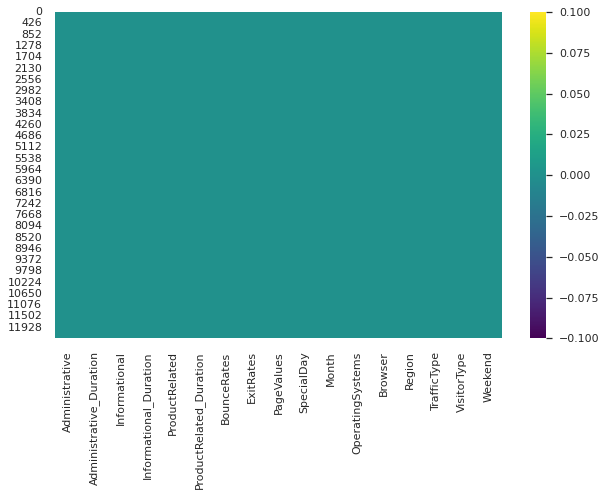

In [9]:
#null visualization sanity check
sns.set(rc={'figure.figsize':(10,6)})
sns.heatmap(df.isnull(), cmap='viridis');

## Univariate Analysis

#### Custom function 
We find ourselves turning to the same methods and visualizations for univariate analysis. The following function will be utilized to standardize our EDA and simplify code.

In [10]:
def distbox (i,df , type = 'numeric',normalize=True):
  """ 
  This function is designed to provide distribution statics and visualizations of dataframe columns
  it takes in a column number and dataframe and can return:
   numerical output -
            1. the skewness of the column
            2. the kurtosis or spread
            3. the descriptive statistics from .describe()
            4. a histogram and boxplot
            
  OR categorical -        
            1. countplot
            2. values counts (either count or as percentages)
  """
  #best practice import dependencies in functions
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  import warnings 
  warnings.filterwarnings("ignore", category=FutureWarning)
  c = df.iloc[:,i]
  plt.figure(figsize=(8,4))
  if type =='numeric':
    plt.subplot(1,2,1);#Histogram location
    sns.distplot(c);#calls a histogram
    plt.title(df.columns[i]);#adds title
    plt.subplot(1,2,2);#Boxplot location
    sns.boxplot(c);#calls a box and whisket plot
    plt.title(df.columns[i]);#adds title
    print("Skewness: %f" %c.skew()) #Adds Skew value
    # If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
    # If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
    # If the skewness is less than -1 or greater than 1, the data are highly skewed
    print("Kurtosis: %f" %c.kurt(skipna = True)) #Adds Kurtosis value (tail-ness)
    # While kurtosis determines the heaviness of the distribution tails.
    # Kurtosis > 3 thin and not spread
    # Kurtosis <3 moderate spread
    print(c.describe()) #Adds summary statistics of the variable


  elif type == 'categorical':
    sns.countplot(c)
    plt.title(df.columns[i]);#adds title
    print(c.value_counts(normalize=normalize))

  print("Nullcount: %f" %c.isnull().sum().sum())
  plt.show() # this will load image to console before executing next line of code

#### Administrative 

Skewness: 1.960357
Kurtosis: 4.701146
count    12330.000000
mean         2.315166
std          3.321784
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         27.000000
Name: Administrative, dtype: float64
Nullcount: 0.000000


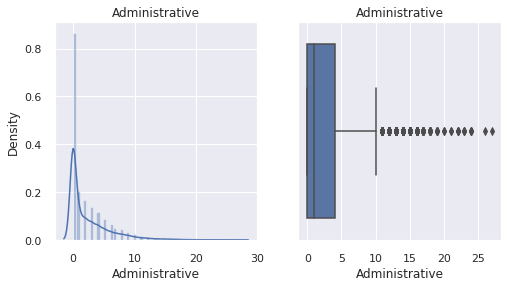

In [11]:
distbox(0,df)

This column is highly right-skewed and contains some outliers. It is also zero-bounded.   
We anticipate this to be a common pattern in this interaction data.
We will look at these outliers now.

In [12]:
# exploring outliers
df[df.iloc[:,0]>10]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
12,12,196.857143,0,0.0,59,1533.025834,0.007214,0.032299,6.048714,0.0,Nov,2,2,1,1,Returning_Visitor,1
20,17,96.160606,5,174.7,75,2549.529127,0.011818,0.047380,0.000000,0.0,Jul,2,2,4,4,Returning_Visitor,0
56,24,290.860369,6,529.7,178,4339.534423,0.003939,0.015263,6.149344,0.4,May,2,2,3,4,Returning_Visitor,0
86,13,869.166667,2,28.2,97,2865.817778,0.009346,0.024206,0.000000,0.0,Oct,2,6,1,1,Returning_Visitor,0
131,14,1097.016667,1,291.2,68,4100.255455,0.007632,0.025614,18.427406,0.0,Aug,1,1,3,3,Returning_Visitor,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12222,12,232.340476,1,19.2,22,504.028571,0.000000,0.003763,0.000000,0.0,Sep,1,1,1,3,New_Visitor,0
12224,11,286.933333,0,0.0,119,7609.820650,0.003200,0.015231,0.000000,0.0,Dec,2,2,3,1,Returning_Visitor,0
12270,14,345.806548,3,195.0,75,5610.686899,0.008046,0.019205,4.452664,0.0,Nov,2,2,3,2,Returning_Visitor,0
12289,14,128.809524,2,41.6,37,1584.770476,0.009302,0.029296,0.000000,0.0,Oct,2,2,1,2,Returning_Visitor,0


We don't see any particular pattern. We will normalize and standardize to optimize model performance.

#### Administrative_Duration

Skewness: 5.615719
Kurtosis: 50.556739
count    12330.000000
mean        80.818611
std        176.779107
min          0.000000
25%          0.000000
50%          7.500000
75%         93.256250
max       3398.750000
Name: Administrative_Duration, dtype: float64
Nullcount: 0.000000


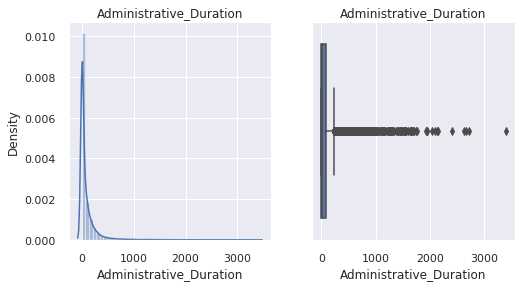

In [13]:
distbox(1,df)

In [14]:
# exploring outliers
df[df.iloc[:,1]>2000]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
177,7,2720.500000,3,353.400000,68,5943.547619,0.032237,0.038623,0.000000,0.0,Jul,3,2,1,13,Returning_Visitor,0
1489,14,2137.112745,0,0.000000,53,4223.409838,0.008772,0.017126,8.886649,0.0,Nov,3,2,2,2,Returning_Visitor,0
4103,10,2407.423810,3,434.300000,486,23050.104140,0.000324,0.011249,0.000000,0.0,Jul,2,2,1,3,Returning_Visitor,0
4512,5,3398.750000,6,2549.375000,449,63973.522230,0.000764,0.027701,0.000000,0.0,Dec,2,2,1,2,Returning_Visitor,0
9203,17,2629.253968,24,2050.433333,705,43171.233380,0.004851,0.015431,0.763829,0.0,May,2,2,1,14,Returning_Visitor,1
9365,5,2156.166667,2,92.000000,15,463.000000,0.036364,0.042208,0.000000,0.0,May,1,2,4,4,Returning_Visitor,1
10918,11,2047.234848,9,1146.666667,45,3641.213151,0.002637,0.014311,7.753880,0.0,Mar,2,2,1,2,Returning_Visitor,0
11702,15,2657.318056,13,1949.166667,343,29970.465970,0.005316,0.028971,0.000000,0.0,Dec,2,2,1,2,Returning_Visitor,0
11901,8,2086.750000,1,46.500000,81,5546.000000,0.002326,0.014563,15.564622,0.0,Nov,2,2,1,2,Returning_Visitor,0


Distribution closely resembles Administrative. 

This column is highly right-skewed and contains some outliers. The extreme outliers may have a negative effect on our model, but may also contain relevant information. We will keep them for now, along with any similar outliers in similar features. 

It is also zero-bounded.   

We will standardize and normalize.


#### Informational

Skewness: 4.036464
Kurtosis: 26.932266
count    12330.000000
mean         0.503569
std          1.270156
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         24.000000
Name: Informational, dtype: float64
Nullcount: 0.000000


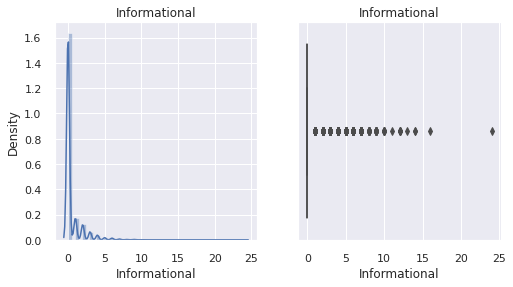

In [15]:
distbox(2,df)

It is interesting that almost none of the user base looked at informational pages.

We will standardize and normalize.

#### Informational_Duration

Skewness: 7.579185
Kurtosis: 76.316853
count    12330.000000
mean        34.472398
std        140.749294
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2549.375000
Name: Informational_Duration, dtype: float64
Nullcount: 0.000000


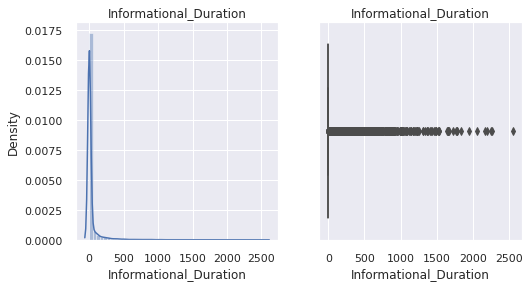

In [16]:
distbox(3,df)

This feature has a higher skew and kurtosis than the `Informational` feature. 
We will standardize and normalize.

#### ProductRelated

Skewness: 4.341516
Kurtosis: 31.211707
count    12330.000000
mean        31.731468
std         44.475503
min          0.000000
25%          7.000000
50%         18.000000
75%         38.000000
max        705.000000
Name: ProductRelated, dtype: float64
Nullcount: 0.000000


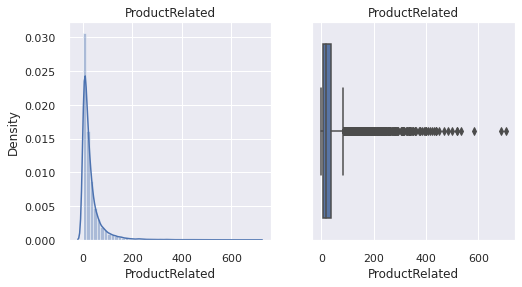

In [17]:
distbox(4,df)

We will standardize and normalize.

#### ProductRelated_Duration

Skewness: 7.263228
Kurtosis: 137.174164
count    12330.000000
mean      1194.746220
std       1913.669288
min          0.000000
25%        184.137500
50%        598.936905
75%       1464.157213
max      63973.522230
Name: ProductRelated_Duration, dtype: float64
Nullcount: 0.000000


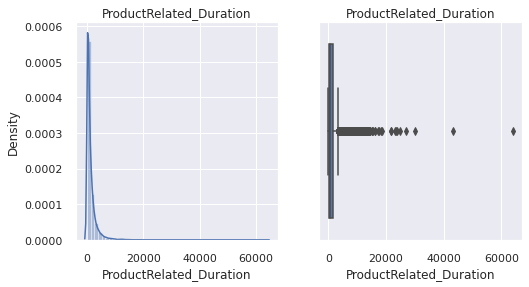

In [18]:
distbox(5,df)

We will standardize and normalize.

#### BounceRates 

Skewness: 2.947855
Kurtosis: 7.723159
count    12330.000000
mean         0.022191
std          0.048488
min          0.000000
25%          0.000000
50%          0.003112
75%          0.016813
max          0.200000
Name: BounceRates, dtype: float64
Nullcount: 0.000000


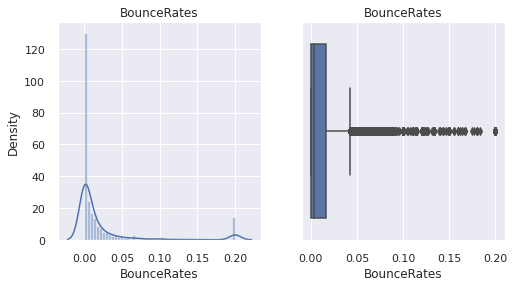

In [19]:
distbox(6,df)

The vast majority of users have a zero (or near 0) bounce rate. This isn't surprising. We will normalize & standardize this feature.

#### ExitRates

Skewness: 2.148789
Kurtosis: 4.017035
count    12330.000000
mean         0.043073
std          0.048597
min          0.000000
25%          0.014286
50%          0.025156
75%          0.050000
max          0.200000
Name: ExitRates, dtype: float64
Nullcount: 0.000000


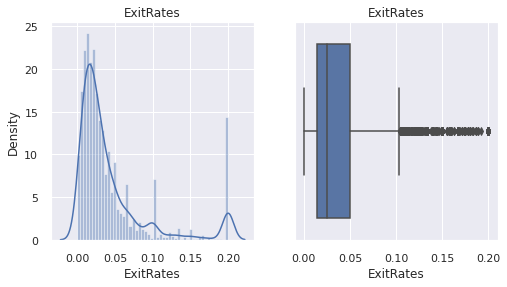

In [20]:
distbox(7,df)

We will normalize and standardize this feature

#### PageValues

Skewness: 6.382964
Kurtosis: 65.635694
count    12330.000000
mean         5.889258
std         18.568437
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        361.763742
Name: PageValues, dtype: float64
Nullcount: 0.000000


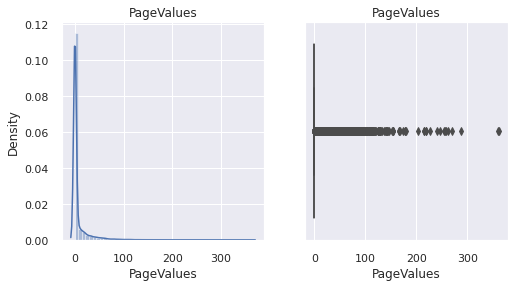

In [21]:
distbox(8,df)

We will standardize and normalize.

#### SpecialDay

0.0    0.898540
0.6    0.028467
0.8    0.026358
0.4    0.019708
0.2    0.014436
1.0    0.012490
Name: SpecialDay, dtype: float64
Nullcount: 0.000000


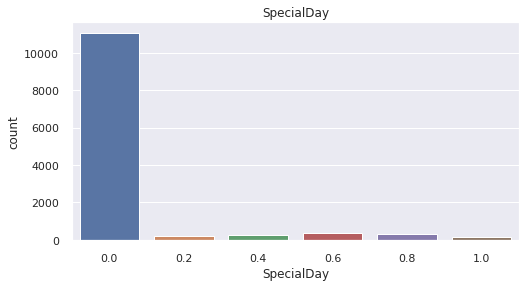

In [22]:
distbox(9,df,type='categorical')

We will combine the sparse classes by making an indicator column.

#### Month

May     0.272830
Nov     0.243147
Mar     0.154663
Dec     0.140065
Oct     0.044526
Sep     0.036334
Aug     0.035118
Jul     0.035036
June    0.023358
Feb     0.014923
Name: Month, dtype: float64
Nullcount: 0.000000


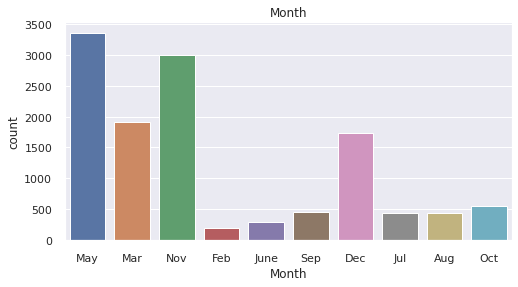

In [23]:
distbox(10,df,type='categorical')

There are only 10 months represented here. We are missing April and January. The granularity of the data is aggregated by user by year. There isn't a lot of information on this feature that we can find, but we are assuming this represents the first month of the user aggregation. An explanation of January being missing can be that users start more often ahead of the winter holidays, thus starting in Dec instead of Jan. We aren't very confident in our assessment, but also are not very worried about the missing months.

#### OperatingSystems

2    0.535361
1    0.209651
3    0.207218
4    0.038767
8    0.006407
6    0.001541
7    0.000568
5    0.000487
Name: OperatingSystems, dtype: float64
Nullcount: 0.000000


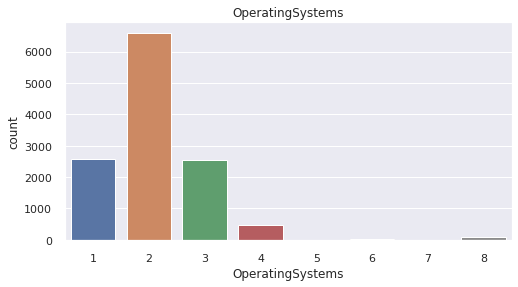

In [24]:
distbox(11,df,type='categorical')

We will combine the sparse classes by turning this into an indicator column for the 2nd operating system to keep the classes even.

#### Browser

2     0.645661
1     0.199676
4     0.059692
5     0.037875
6     0.014112
10    0.013220
8     0.010949
3     0.008516
13    0.004947
7     0.003974
12    0.000811
11    0.000487
9     0.000081
Name: Browser, dtype: float64
Nullcount: 0.000000


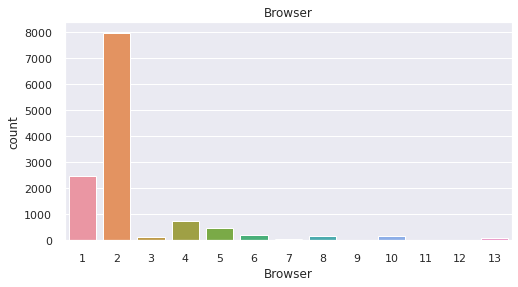

In [25]:
distbox(12,df,type='categorical')

We will turn this into an indicator column for the 2nd browser.

#### Region

1    0.387672
3    0.194891
4    0.095864
2    0.092133
6    0.065288
7    0.061719
9    0.041444
8    0.035199
5    0.025791
Name: Region, dtype: float64
Nullcount: 0.000000


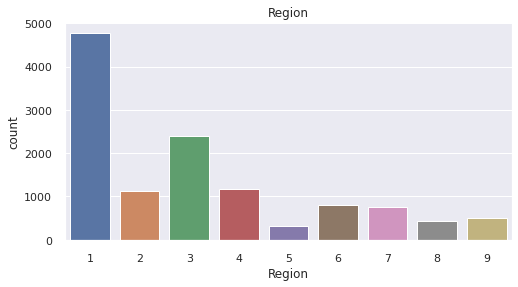

In [26]:
distbox(13,df,type='categorical')

We will combine sparse classes for every region below 9% (5-9)

#### TrafficType

2     0.317356
1     0.198783
3     0.166423
4     0.086699
13    0.059854
10    0.036496
6     0.036010
8     0.027818
5     0.021087
11    0.020032
20    0.016058
9     0.003406
7     0.003244
15    0.003082
19    0.001379
14    0.001054
18    0.000811
16    0.000243
12    0.000081
17    0.000081
Name: TrafficType, dtype: float64
Nullcount: 0.000000


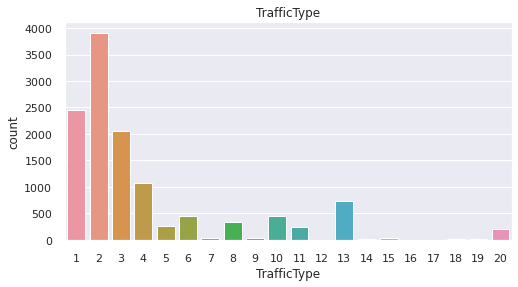

In [27]:
distbox(14,df,type='categorical')

We will combine sparse classes for anything below 5% of the dataset and then dummy. We suspect there may be some ordinality, though we cannot find any specific information on this feature to clarify the datatype.

#### VisitorType

Returning_Visitor    0.855718
New_Visitor          0.137388
Other                0.006894
Name: VisitorType, dtype: float64
Nullcount: 0.000000


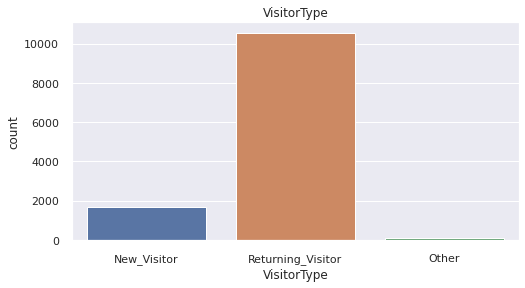

In [28]:
distbox(15,df,type='categorical')

This Other value is concerning.

In [29]:
# exploring outliers
df[df.iloc[:,15]=='Other']

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
34,3,65.00,0,0.0,29,386.262121,0.0,0.000667,0.000000,0.0,Nov,8,2,9,2,Other,0
106,4,63.00,0,0.0,10,565.500000,0.0,0.015385,0.000000,0.0,Dec,8,13,9,20,Other,0
295,0,0.00,0,0.0,13,1314.083333,0.0,0.008333,103.061083,0.0,Dec,8,13,9,20,Other,0
380,0,0.00,0,0.0,1,0.000000,0.2,0.200000,0.000000,0.0,Nov,2,5,2,1,Other,0
395,0,0.00,0,0.0,9,396.166667,0.0,0.022222,0.000000,0.0,Nov,3,2,8,13,Other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12043,0,0.00,0,0.0,1,0.000000,0.2,0.200000,0.000000,0.0,Nov,3,2,4,1,Other,0
12133,1,29.25,1,0.0,3,67.666667,0.0,0.040000,0.000000,0.0,Dec,8,13,9,20,Other,0
12168,0,0.00,0,0.0,3,59.000000,0.0,0.066667,0.000000,0.0,Dec,1,1,3,2,Other,0
12264,6,723.50,2,410.5,5,109.000000,0.0,0.015385,0.000000,0.0,Nov,2,5,2,2,Other,0


We don't see any patterns in the data. This is sparse enough that we will turn the feature into an indicator column.

#### Weekend

0    0.767397
1    0.232603
Name: Weekend, dtype: float64
Nullcount: 0.000000


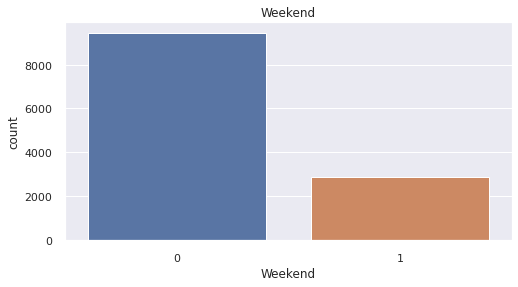

In [30]:
distbox(16,df,type='categorical')

We will leave this feature alone (perhaps we will oversample it)

## Multivariate Analysis

#### Quantitative Independence

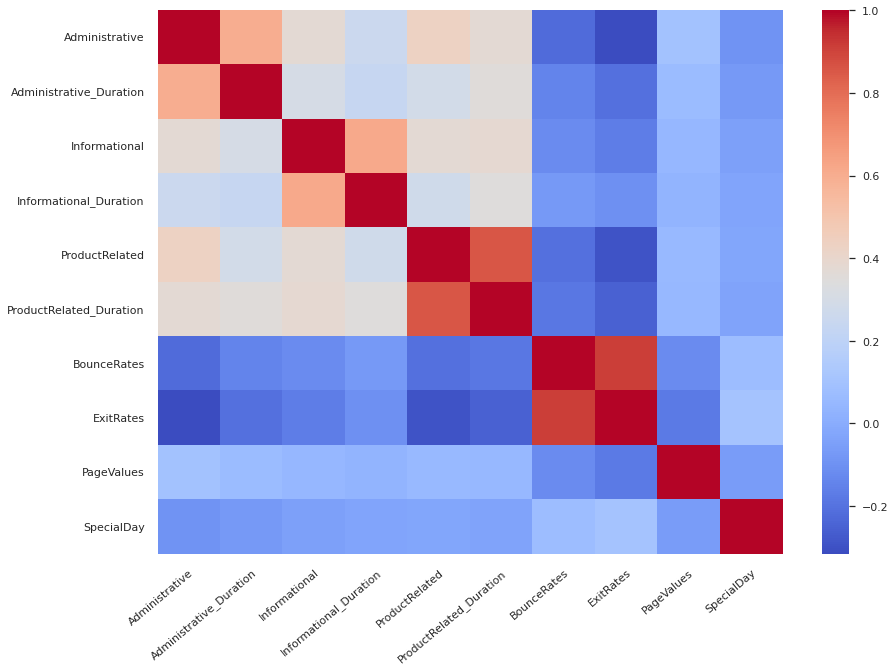

In [31]:
#Correlation analysis for columns which are not categorical
plt.figure(figsize=(14,10))
sns.heatmap(df.iloc[:,:10].corr(),cmap='coolwarm',annot=False);
plt.xticks(rotation=40 , rotation_mode='anchor',ha="right");

There are strong relationships between the type of page and the duration of the type of page, which is expected. There do not appear to be strongly predictive values between the other features.

#### Categorical Independence¶


In [32]:
df.columns[np.r_[9,11:15,16]]

Index(['SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'Weekend'],
      dtype='object')

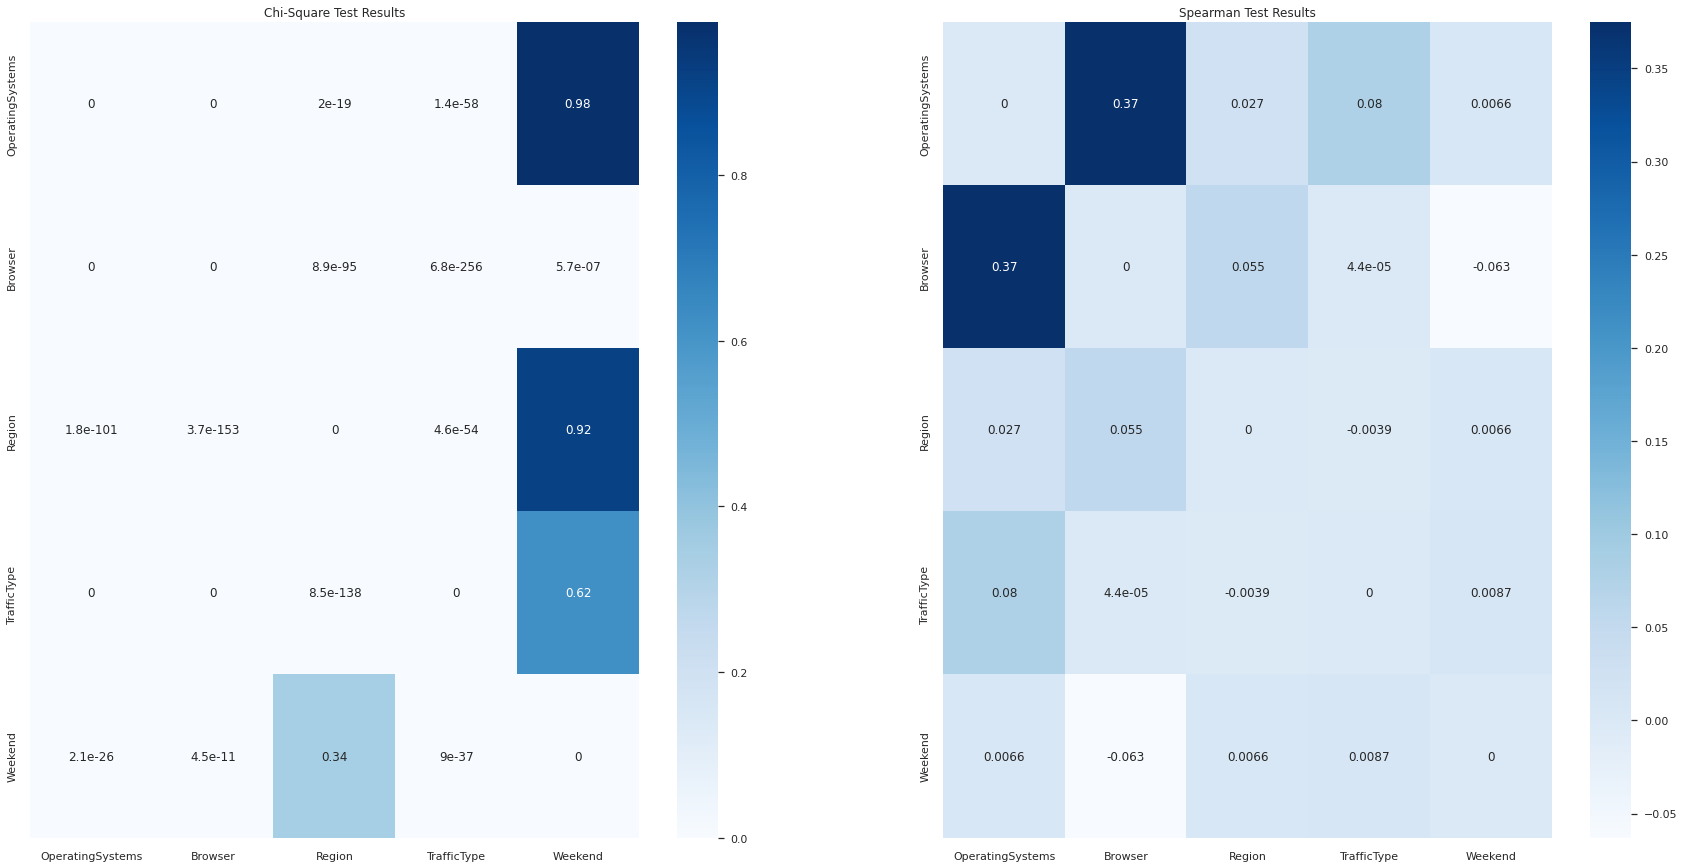

In [33]:
from sklearn.feature_selection import chi2
from scipy.stats import spearmanr
cat_columns = ['OperatingSystems','Browser', 'Region', 'TrafficType','Weekend']#Month and VisitorType left out of analysis because they are strings. We will look at them after the data prep

chi_ps =[]
spearman = []
for cat in cat_columns:
  intermediate_P = []
  intermediat_spear = []
  for second_cat in cat_columns:
    if cat == second_cat:
      intermediate_P.append(0)
      intermediat_spear.append(0)
      continue
    chi = chi2(df[cat].values.reshape(-1, 1),df[second_cat].values.reshape(-1, 1))
    intermediate_P.append(chi[1][0])
    spear = spearmanr(df[cat].values.reshape(-1, 1),df[second_cat].values.reshape(-1, 1))
    intermediat_spear.append(spear[0])
  chi_ps.append(intermediate_P)
  spearman.append(intermediat_spear)


df_pvalues = pd.DataFrame(data= chi_ps,index=cat_columns,columns=cat_columns)
df_spearman = pd.DataFrame(data= spearman,index=cat_columns,columns=cat_columns)
#print(intermediat_spear)
#df_pvalues
fig = plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
sns.heatmap(df_pvalues, annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.subplot(1,2,2)
sns.heatmap(df_spearman, annot=True, cmap='Blues')
plt.title('Spearman Test Results')
plt.show()

**conclusions**

The results of our Chi^2 and spearman indicate that our categorical variables are not independent. This makes intuitive sense (ie browser/operating system safari is only available on Mac systems as an example). In terms of predictive use, we will be using feature selection techniques to identify which if any of these to keep.

# Data Preparation (Pre-Clustering)
We will now address the data integrity and usability issues we identified in our EDA.

### Create df_prep

In [34]:
df_prep = df.copy()

## Categorical Updates

### SpecialDay

In [35]:
#create city 2 indicator
df_prep['SpecialDay'] = (df_prep['SpecialDay'] != 0).astype(int);

### Operating Systems

In [36]:
#create os2 indicator column and dropping the old feature
df_prep.insert(11, 'os2', (df_prep['OperatingSystems'] == "2").astype(int))
df_prep.drop(columns=['OperatingSystems'], inplace=True)

### Browser

In [37]:
#creating browser2 indicator column and dropping the old feature
df_prep.insert(12, 'browser2', (df_prep['Browser'] == 2).astype(int))
df_prep.drop(columns=['Browser'], inplace=True)
df_prep.head()#sanity check

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,os2,browser2,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0,May,0,0,1,2,New_Visitor,1
1,0,0.0,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0,Mar,0,1,4,2,Returning_Visitor,0
2,4,37.5,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0,Nov,0,1,9,2,New_Visitor,0
3,4,115.7,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0,Nov,0,0,2,3,Returning_Visitor,0
4,1,60.0,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0,May,0,1,3,4,Returning_Visitor,0


### Region

We will combine sparse classes (5-9)

In [38]:
df_prep['Region'].replace(6,5,inplace=True)
df_prep['Region'].replace(7,5,inplace=True)
df_prep['Region'].replace(8,5,inplace=True)
df_prep['Region'].replace(9,5,inplace=True)

### TrafficType
As a reminder, we will combine any TrafficType that comprises less than 5% of the data into an "Other" variable.

In [39]:
df_prep['TrafficType'].replace(6,5,inplace=True)
df_prep['TrafficType'].replace(10,5,inplace=True)
df_prep['TrafficType'].replace(8,5,inplace=True)
df_prep['TrafficType'].replace(11,5,inplace=True)
df_prep['TrafficType'].replace(20,5,inplace=True)
df_prep['TrafficType'].replace(9,5,inplace=True)
df_prep['TrafficType'].replace(7,5,inplace=True)
df_prep['TrafficType'].replace(15,5,inplace=True)
df_prep['TrafficType'].replace(19,5,inplace=True)
df_prep['TrafficType'].replace(14,5,inplace=True)
df_prep['TrafficType'].replace(18,5,inplace=True)
df_prep['TrafficType'].replace(16,5,inplace=True)
df_prep['TrafficType'].replace(12,5,inplace=True)
df_prep['TrafficType'].replace(17,5,inplace=True)

### VisitorType

In [40]:
#creating Returning_Visitor indicator column and dropping the old feature
df_prep.insert(15, 'Returning_Visitor', (df_prep['VisitorType'] == "Returning_Visitor").astype(int))
df_prep.drop(columns=['VisitorType'], inplace=True)
df_prep.head()#sanity check

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,os2,browser2,Region,TrafficType,Returning_Visitor,Weekend
0,0,0.0,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0,May,0,0,1,2,0,1
1,0,0.0,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0,Mar,0,1,4,2,1,0
2,4,37.5,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0,Nov,0,1,5,2,0,0
3,4,115.7,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0,Nov,0,0,2,3,1,0
4,1,60.0,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0,May,0,1,3,4,1,0


## 1 Hot Encoding

In [41]:
#dummying TrafficType, Region, Month, using the patsy library
from patsy import dmatrix
formula = """C(TrafficType) + C(Region) + C(Month)"""
dum = dmatrix(formula, df_prep,return_type='dataframe').astype('int32')
df_prep.drop(['TrafficType','Region','Month'], axis=1,inplace=True)
df_prep = pd.concat([df_prep, dum], axis=1)
df_prep.drop(['Intercept'], axis=1, inplace=True)
del dum
df_prep.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,os2,browser2,Returning_Visitor,Weekend,C(TrafficType)[T.2],C(TrafficType)[T.3],C(TrafficType)[T.4],C(TrafficType)[T.5],C(TrafficType)[T.13],C(Region)[T.2],C(Region)[T.3],C(Region)[T.4],C(Region)[T.5],C(Month)[T.Dec],C(Month)[T.Feb],C(Month)[T.Jul],C(Month)[T.June],C(Month)[T.Mar],C(Month)[T.May],C(Month)[T.Nov],C(Month)[T.Oct],C(Month)[T.Sep]
0,0,0.0,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0.0,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,4,37.5,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,4,115.7,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,1,60.0,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


## Normalize & Standardize

In [42]:
from sklearn.preprocessing import power_transform as pt 

columns = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 'ProductRelated', 
           'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']

for column in columns:#iterate over identified columns
  a = df_prep[[column]]
  df_prep[column] = pt(a,method='yeo-johnson')#yeo-johnson used because we have 0 values

df_prep[columns].head()#sanity check

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
0,-0.990128,-0.996659,-0.520489,-0.491697,-0.619245,-0.532374,-0.799209,-0.029540,1.982295
1,-0.990128,-0.996659,-0.520489,-0.491697,-0.168286,0.397858,0.423405,0.655157,-0.529409
2,1.040186,0.662790,1.964686,2.069941,-1.132804,-0.912032,-0.799209,-0.581230,-0.529409
3,1.040186,1.053114,-0.520489,-0.491697,-0.057127,0.085413,-0.799209,-0.907817,-0.529409
4,0.091737,0.830316,1.823038,1.969567,0.356015,0.099835,-0.799209,-1.478985,-0.529409


# Cluster Modeling
We will now perform hierarchical and K-means clustering to identify the number of clusters in our data, and pave the way for our predictive models.

In [43]:
df_prep.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,os2,browser2,Returning_Visitor,Weekend,C(TrafficType)[T.2],C(TrafficType)[T.3],C(TrafficType)[T.4],C(TrafficType)[T.5],C(TrafficType)[T.13],C(Region)[T.2],C(Region)[T.3],C(Region)[T.4],C(Region)[T.5],C(Month)[T.Dec],C(Month)[T.Feb],C(Month)[T.Jul],C(Month)[T.June],C(Month)[T.Mar],C(Month)[T.May],C(Month)[T.Nov],C(Month)[T.Oct],C(Month)[T.Sep]
0,-0.990128,-0.996659,-0.520489,-0.491697,-0.619245,-0.532374,-0.799209,-0.029540,1.982295,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,-0.990128,-0.996659,-0.520489,-0.491697,-0.168286,0.397858,0.423405,0.655157,-0.529409,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,1.040186,0.662790,1.964686,2.069941,-1.132804,-0.912032,-0.799209,-0.581230,-0.529409,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,1.040186,1.053114,-0.520489,-0.491697,-0.057127,0.085413,-0.799209,-0.907817,-0.529409,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.091737,0.830316,1.823038,1.969567,0.356015,0.099835,-0.799209,-1.478985,-0.529409,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [44]:
df_prep.shape

(12330, 32)

## Hierarchical Exploration

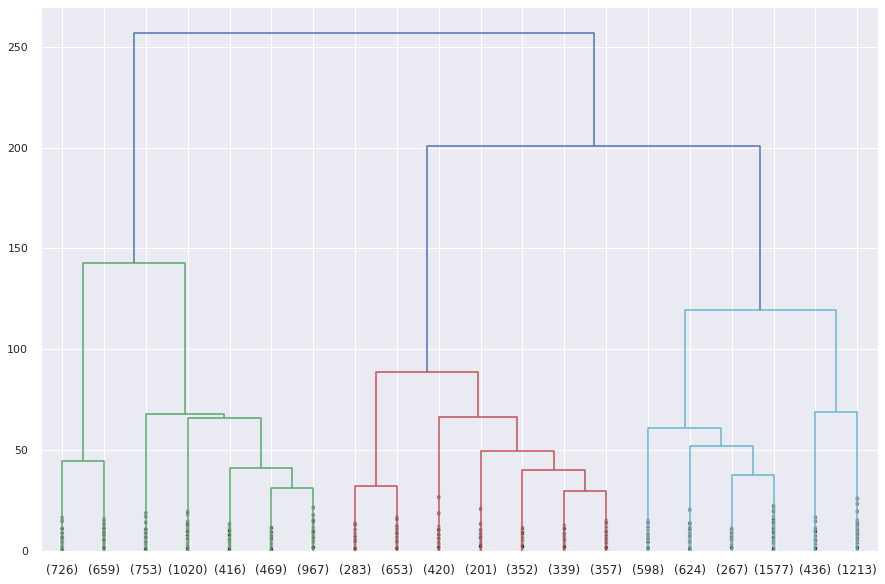

In [45]:
from scipy.cluster import hierarchy
fig, ax = plt.subplots(figsize=(15, 10))
dend = hierarchy.dendrogram(
    hierarchy.linkage(df_prep, method="ward"),
    truncate_mode="lastp",
    p=20,
    show_contracted=True,
)

From this dendrogram,  we would expect either 2 or 3 clusters.

## K-Means Clustering Exploration


Text(0, 0.5, 'Inertia')

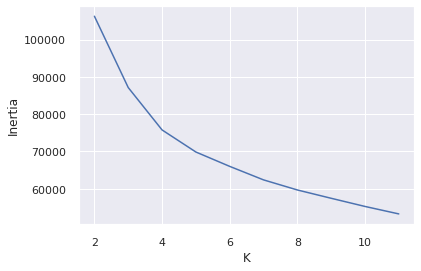

In [46]:
#If we didn't know we were looking for k=2
from sklearn.cluster import KMeans
inertias = []
sizes = range(2, 12)
for k in sizes:
    k2 = KMeans(random_state=42, n_clusters=k)
    k2.fit(df_prep)
    inertias.append(k2.inertia_)
fig, ax = plt.subplots(figsize=(6, 4))
pd.Series(inertias, index=sizes).plot(ax=ax)
ax.set_xlabel("K")
ax.set_ylabel("Inertia")

We might choose 4 clusters from this inertia plot, but we will generate a few more metrics to help us evaluate.

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


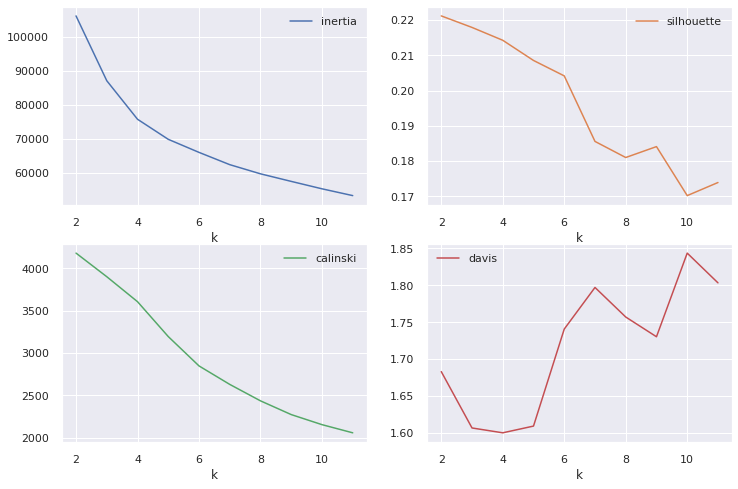

In [47]:
from sklearn import metrics
inertias = []
sils = []
chs = []
dbs = []
sizes = range(2, 12)



for k in sizes:
    k2 = KMeans(random_state=42, n_clusters=k)
    k2.fit(df_prep)
    inertias.append(k2.inertia_)
    sils.append(
        metrics.silhouette_score(df_prep, k2.labels_)
    );
    chs.append(
        metrics.calinski_harabasz_score(
            df_prep, k2.labels_
        )
    )
    dbs.append(
        metrics.davies_bouldin_score(
            df_prep, k2.labels_
        )
    )
fig, ax = plt.subplots(figsize=(12, 8))
plt.setp(ax,xticks=[2,3,4,5,6,7,8,9])# Set the xticks 
(
    pd.DataFrame(
        {
            "inertia": inertias,
            "silhouette": sils,
            "calinski": chs,
            "davis": dbs,
            "k": sizes,
        }
    )
    .set_index("k")
    .plot(ax=ax, subplots=True, layout=(2, 2))
);

*   Inertia Plot: Bend in the elbow is better. We would choose 4 clusters
*   Silhouette Coefficient: The higher the better. We would choose 2 clusters
*   Calinski Index: The higher the better. We would choose 2 clusters
*   Davis Index: Ranges from 0 and up. The closer to 0 the better. We would choose 4 clusters.

From these metrics, we would expect either 2 or 4 clusters.

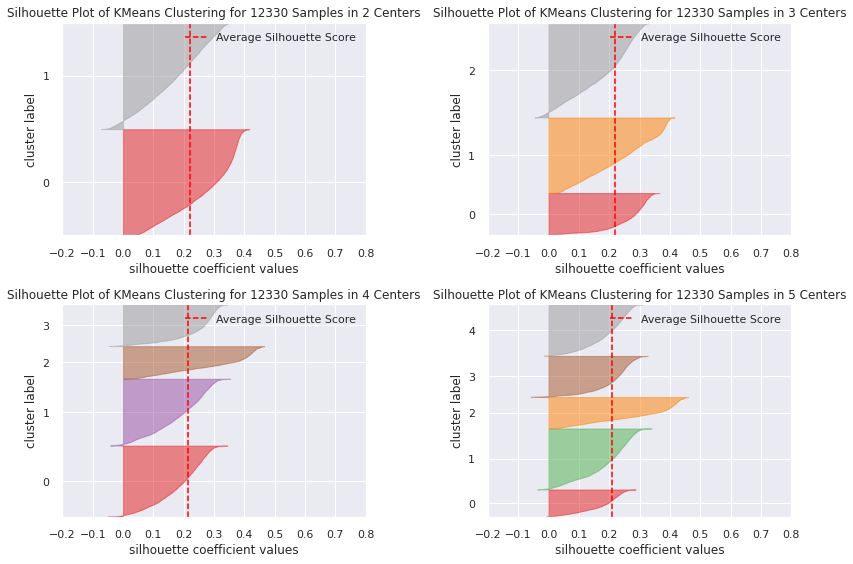

In [48]:
from yellowbrick.cluster.silhouette import SilhouetteVisualizer

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.reshape(4)
for i, k in enumerate(range(2, 6)):
    ax = axes[i]
    sil = SilhouetteVisualizer(
        KMeans(n_clusters=k, random_state=42),
        ax=ax,
    )
    sil.fit(df_prep)
    sil.finalize()
    ax.set_xlim(-0.2, 0.8)
plt.tight_layout()

From the silhouette plots, we would expect either 2 or 3 clusters which are the most similar shapes and sizes. The plot with 2 clusters provides the most uniform silhouettes and would be the number we lean toward.

## K-Means Clustering Application



In [49]:
km = KMeans(init="k-means++",
            n_clusters=2,
            max_iter=300,
            random_state=42)

# fit the model
km.fit(df_prep)
print(f'Converged after {km.n_iter_} iterations')

Converged after 8 iterations


In [50]:
#applying k-means to the data set and storing the output 
clusters = km.predict(df_prep)

In [51]:
#adding it back to the dataframe 
df_prep['Revenue'] = pd.Series(clusters, index=df_prep.index)
df_prep.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,os2,browser2,Returning_Visitor,Weekend,C(TrafficType)[T.2],C(TrafficType)[T.3],C(TrafficType)[T.4],C(TrafficType)[T.5],C(TrafficType)[T.13],C(Region)[T.2],C(Region)[T.3],C(Region)[T.4],C(Region)[T.5],C(Month)[T.Dec],C(Month)[T.Feb],C(Month)[T.Jul],C(Month)[T.June],C(Month)[T.Mar],C(Month)[T.May],C(Month)[T.Nov],C(Month)[T.Oct],C(Month)[T.Sep],Revenue
0,-0.990128,-0.996659,-0.520489,-0.491697,-0.619245,-0.532374,-0.799209,-0.029540,1.982295,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,-0.990128,-0.996659,-0.520489,-0.491697,-0.168286,0.397858,0.423405,0.655157,-0.529409,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,1.040186,0.662790,1.964686,2.069941,-1.132804,-0.912032,-0.799209,-0.581230,-0.529409,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,1.040186,1.053114,-0.520489,-0.491697,-0.057127,0.085413,-0.799209,-0.907817,-0.529409,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0.091737,0.830316,1.823038,1.969567,0.356015,0.099835,-0.799209,-1.478985,-0.529409,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


# Exploratory Data Analysis (Post-Clustering)

We will start our post-Clustering EDA by looking at sum summary statistics for our two clusters and comparing the underlying data they are associated with utilizing sweetviz.

## Revenue

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


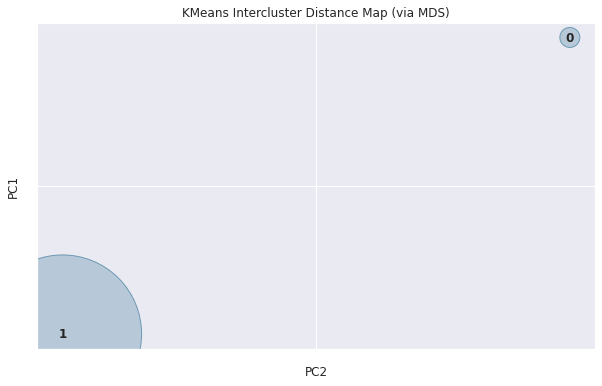

In [52]:
from yellowbrick.cluster.icdm import InterclusterDistance
visualizer = InterclusterDistance(km, 
                                  #embedding='tsne' tried another embeding to see effect
                                  legend=False
                                  )
visualizer.fit(df_prep.drop(labels='Revenue',axis=1));

visualizer.show();

**analysis:** the KNN model has found two very distinct classes based on being maximally spaced apart on this graph. The size of the circles represents the fact that one class ended up with more members than the other, this is not significantly helpful information with just 2 classes.

1    0.50073
0    0.49927
Name: k-means k=2, dtype: float64
Nullcount: 0.000000


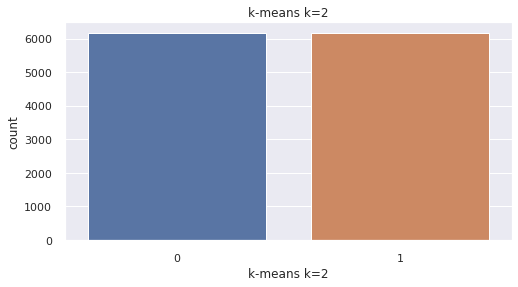

In [53]:
distbox(0,pd.DataFrame(clusters,columns=['k-means k=2']),type='categorical')

False    0.845255
True     0.154745
Name: Revenue, dtype: float64
Nullcount: 0.000000


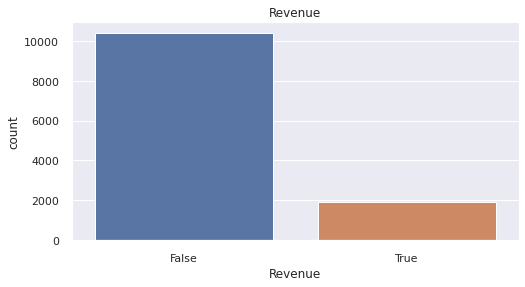

In [54]:
distbox(0,df_r,type='categorical')

**conclusions** our K-means algorithm has created two nearly equally sized clusters. From our domain knowledge, we know when users come to a retail sales website they are usually much more likely to NOT purchase so this is a concerning result. 


## Univariate Review

In [55]:
import sweetviz  as sv
my_report = sv.compare_intra(df_prep, df_prep["Revenue"] == 1, ["bought", "didn't buy"])

                                             |          | [  0%]   00:00 -> (? left)


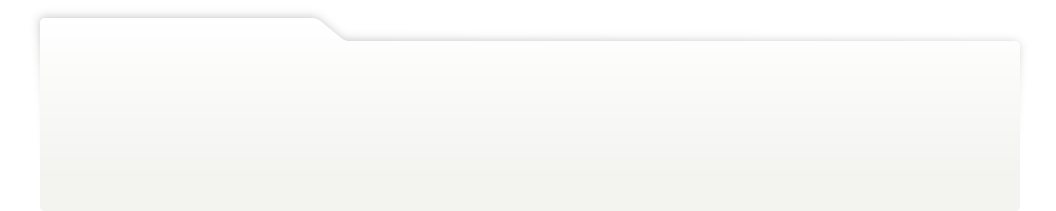
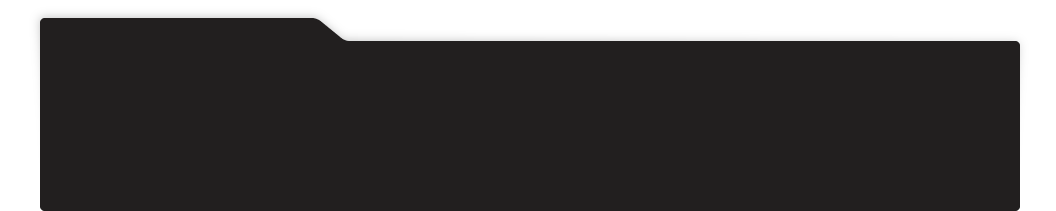
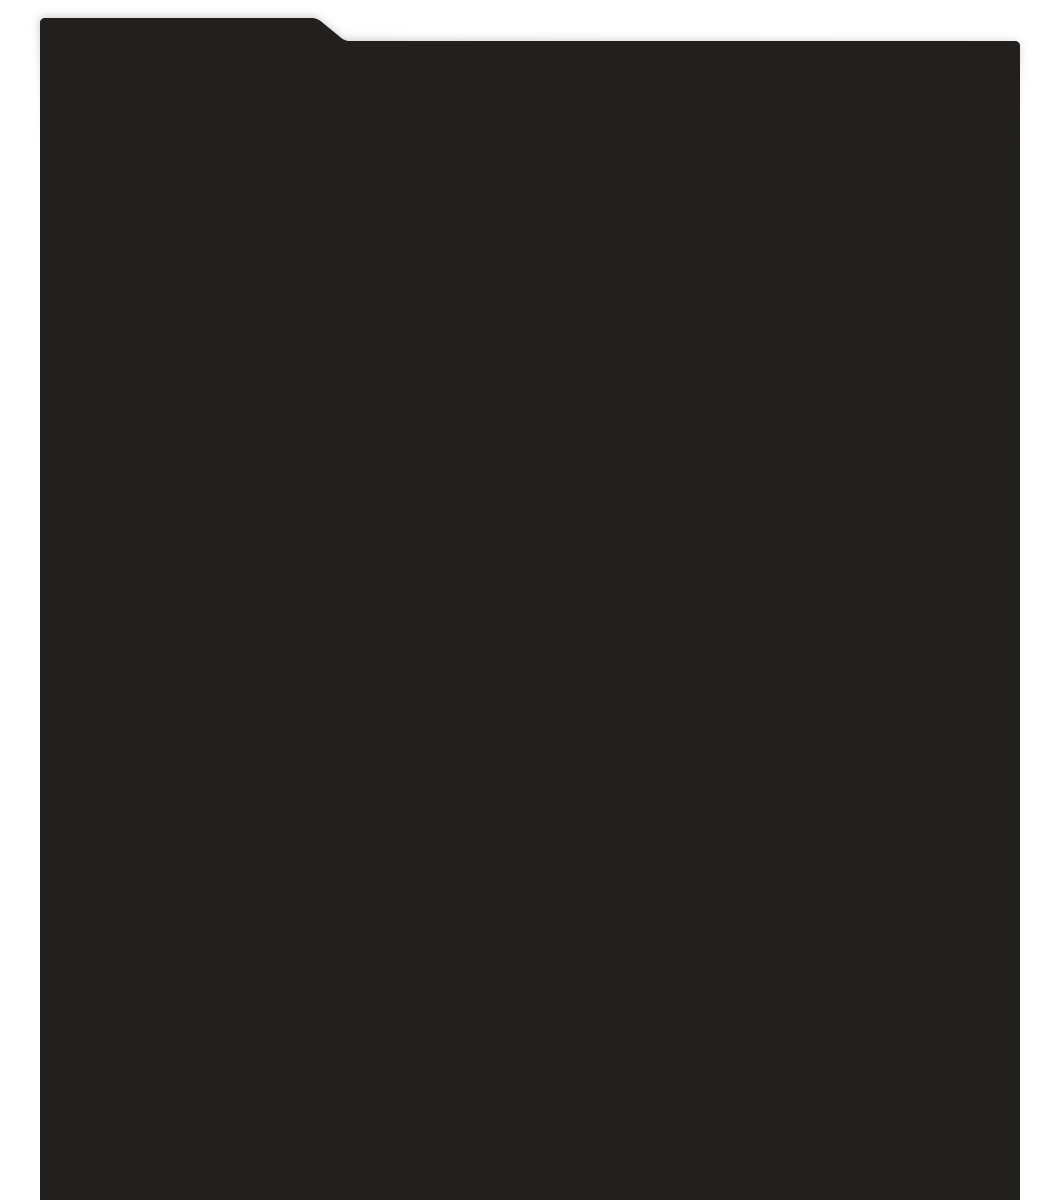
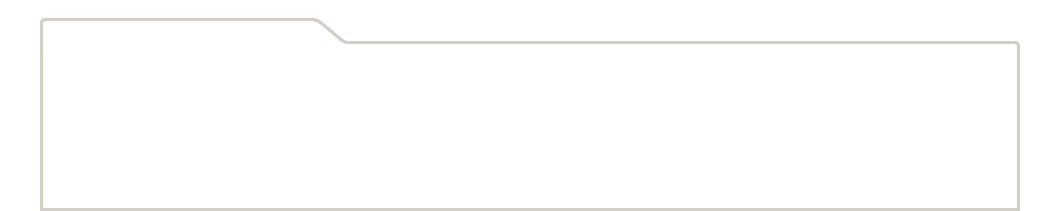
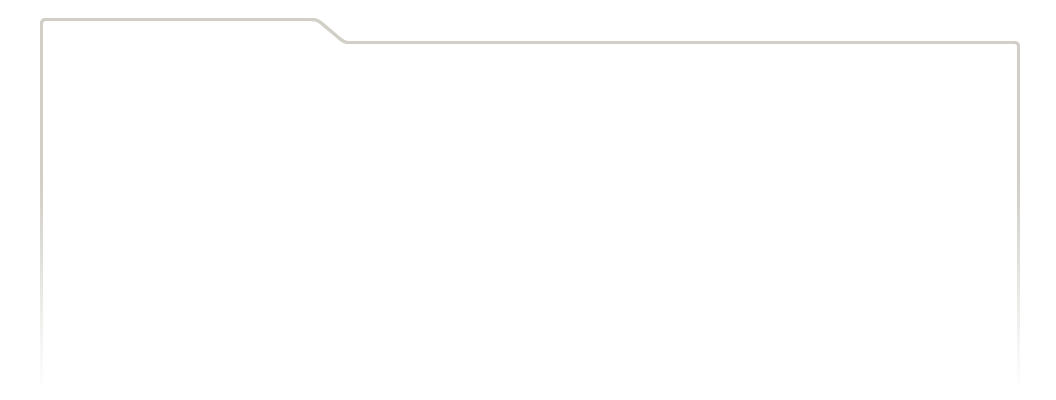
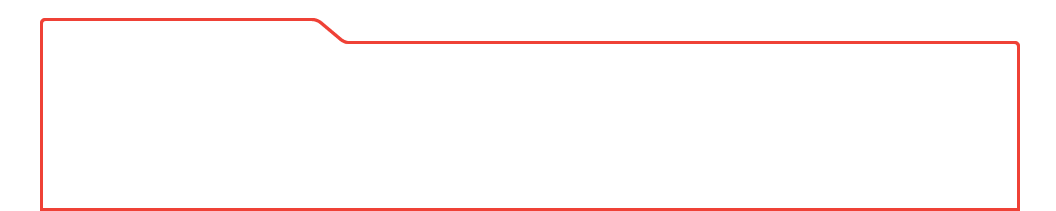
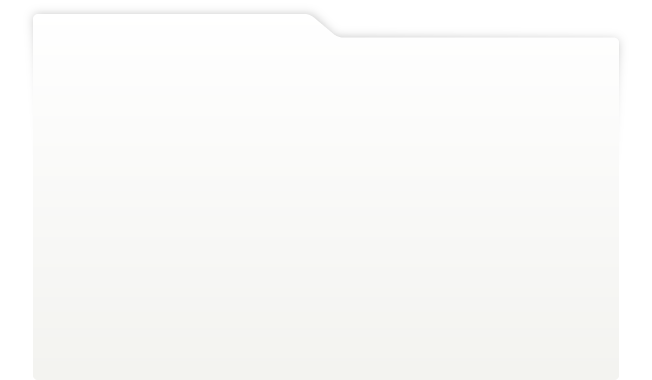
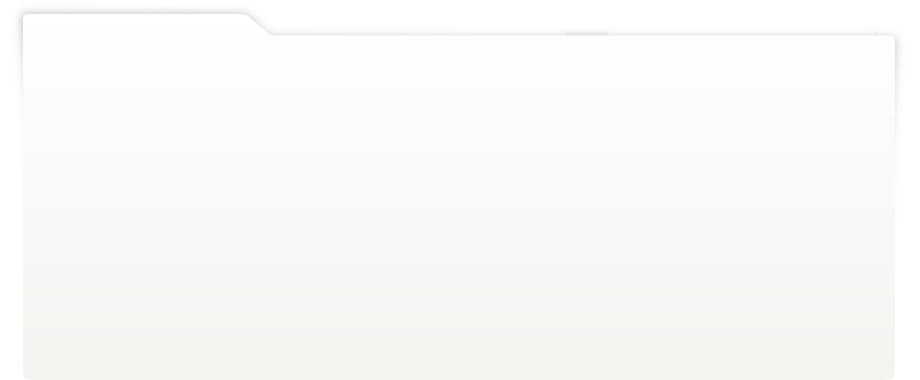
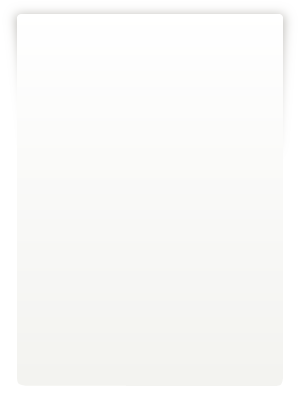
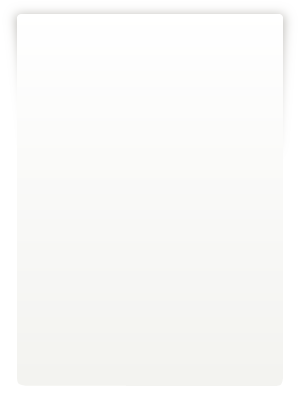
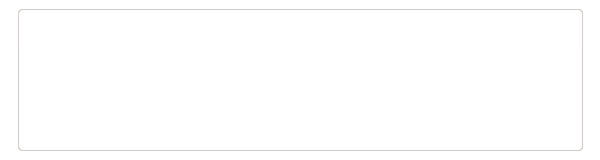
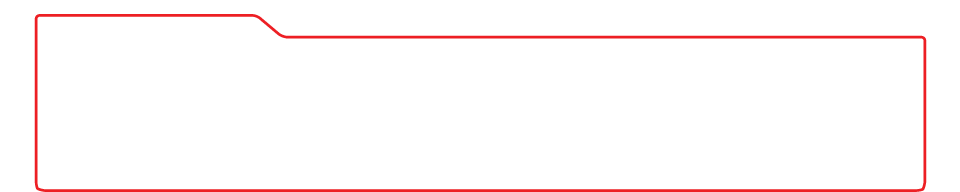
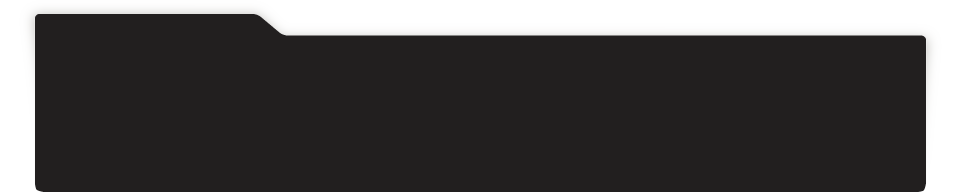
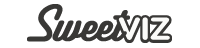
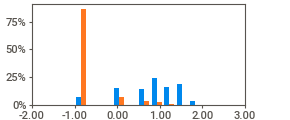
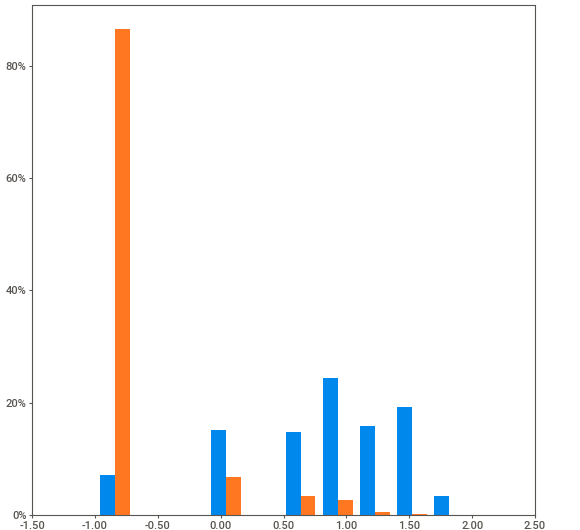
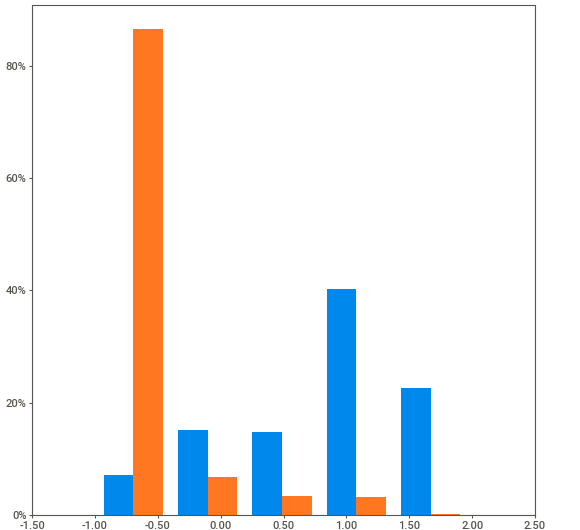
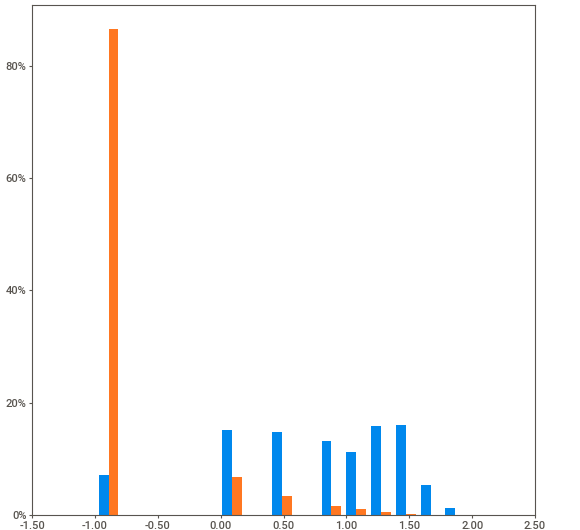
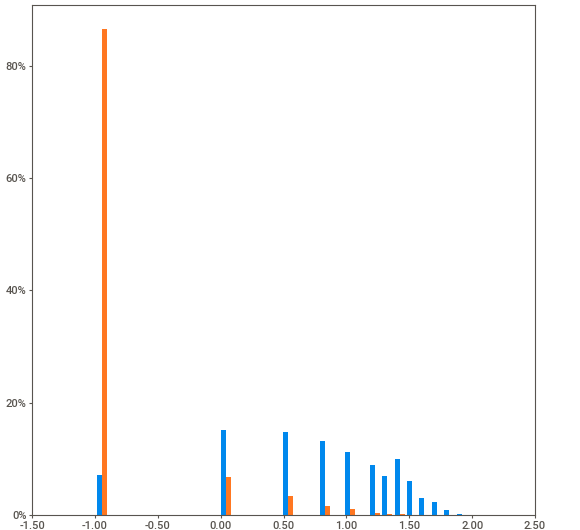
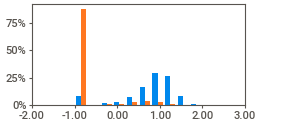
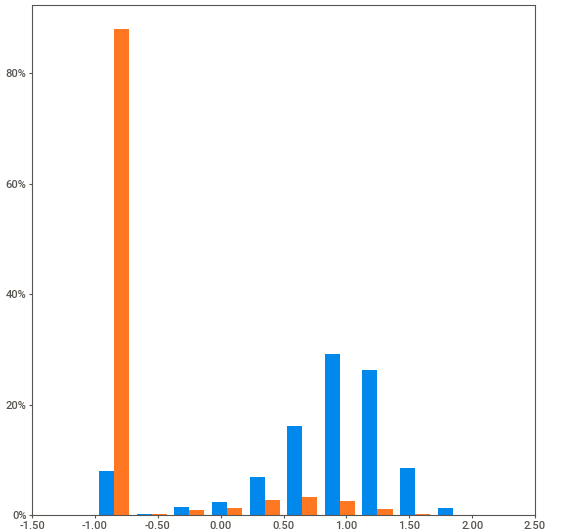
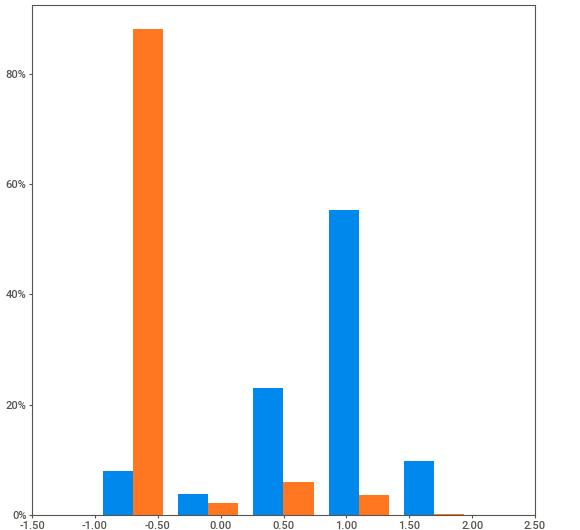
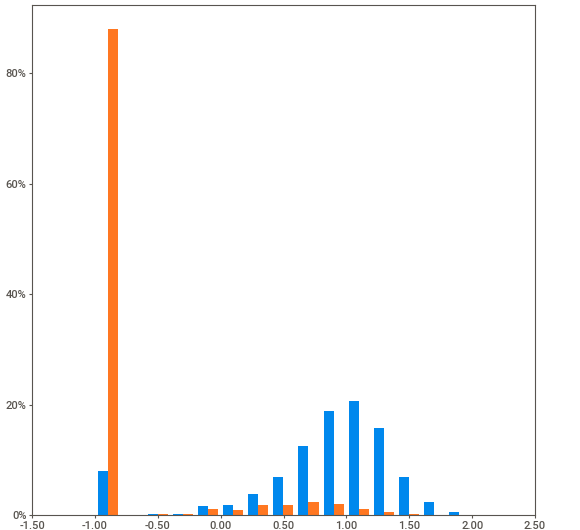
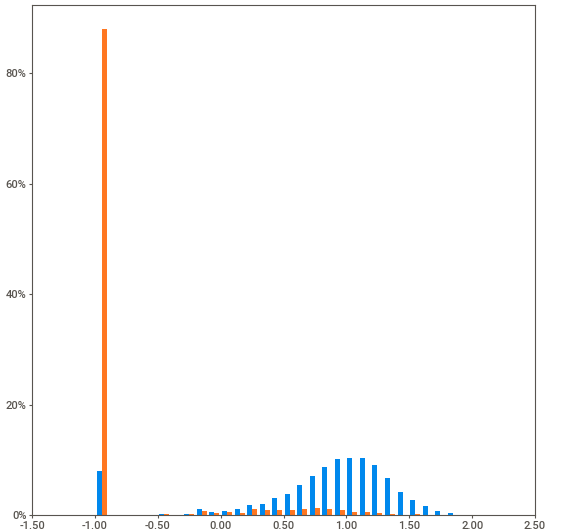
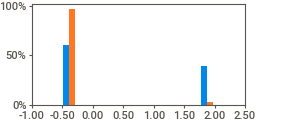
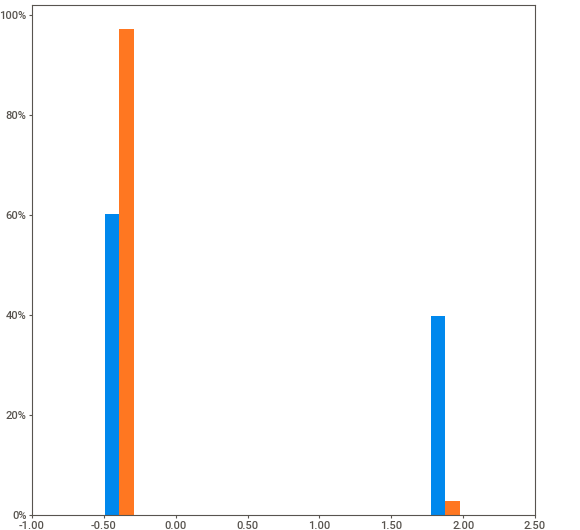
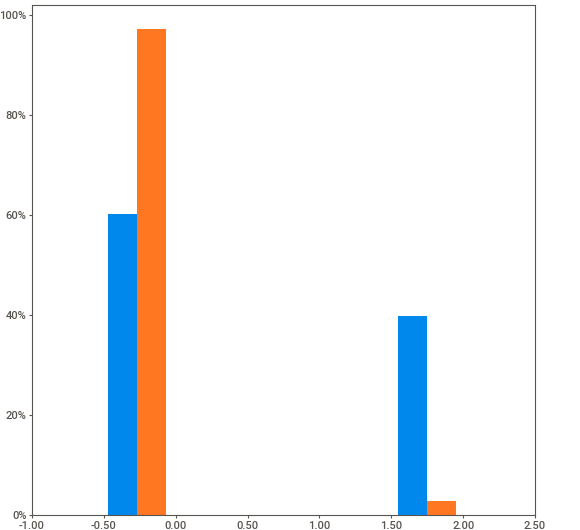
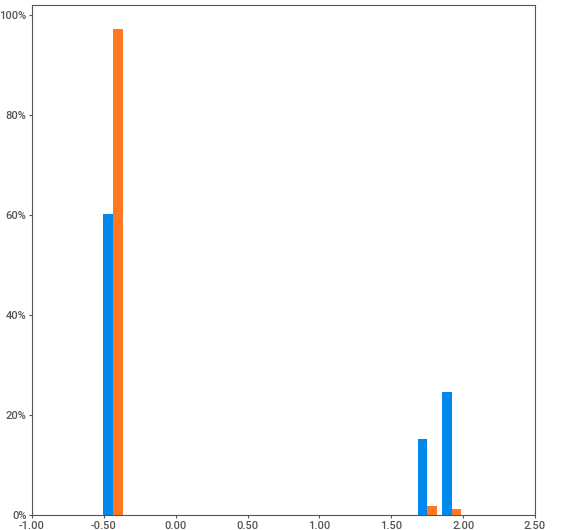
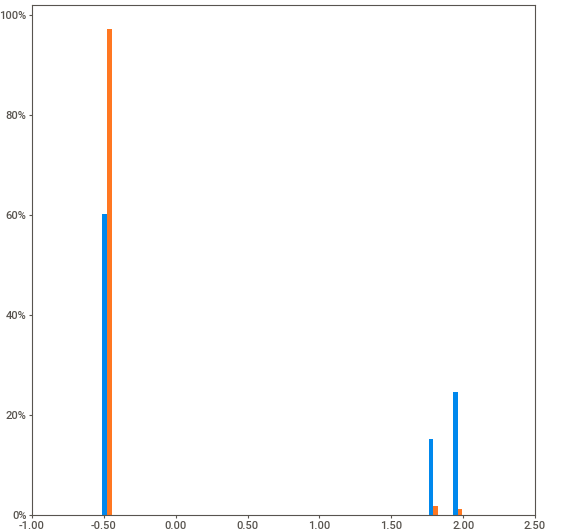
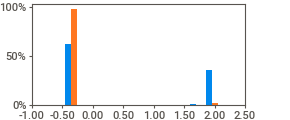
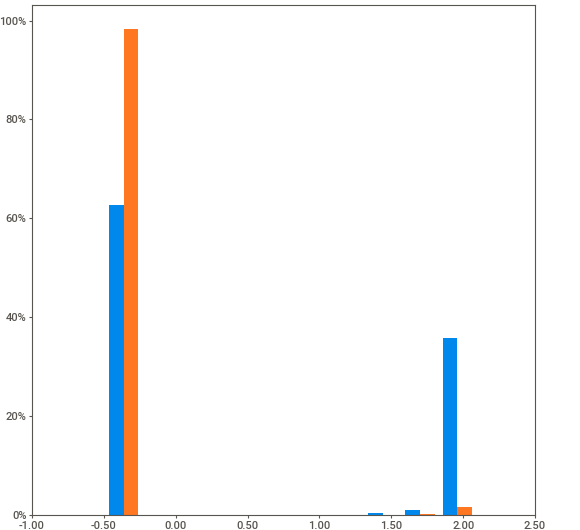
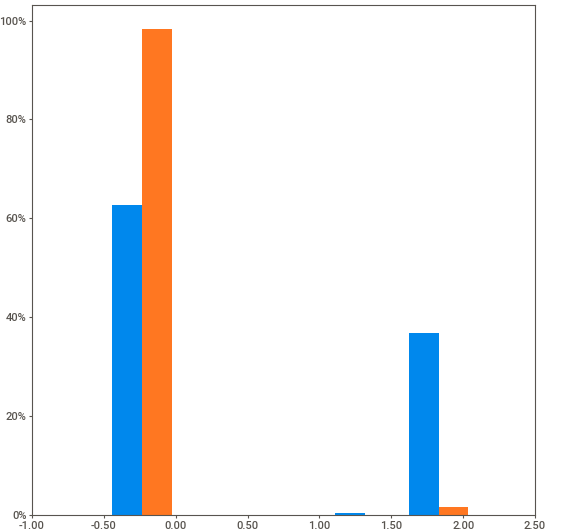
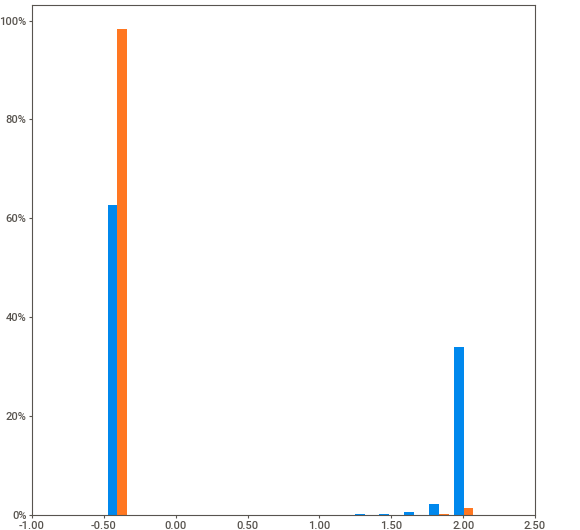
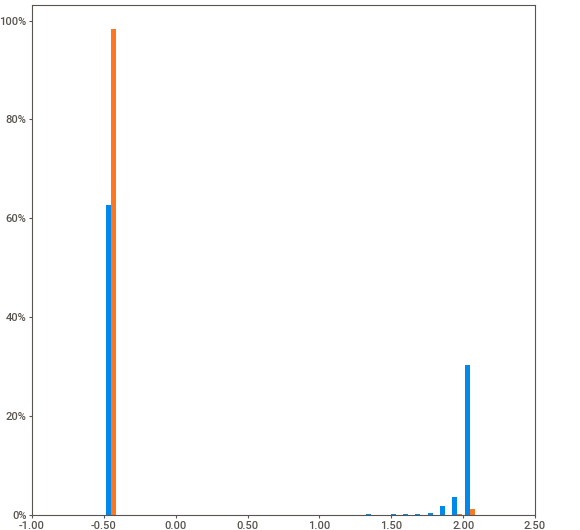
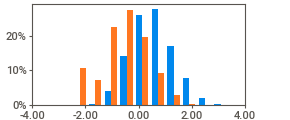
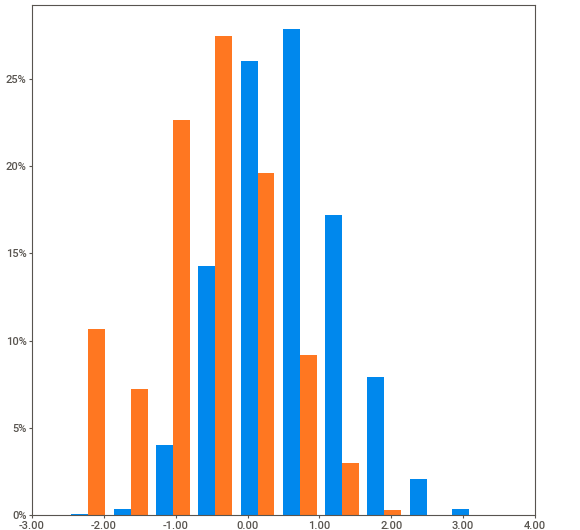
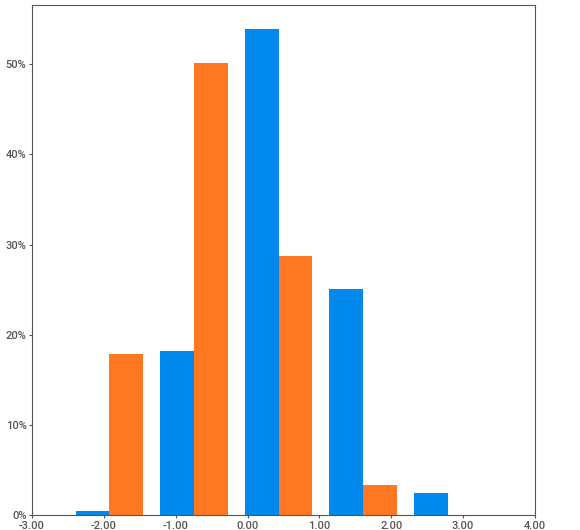
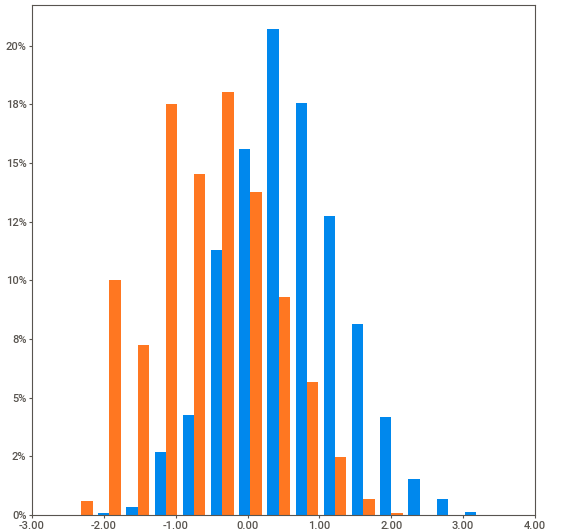
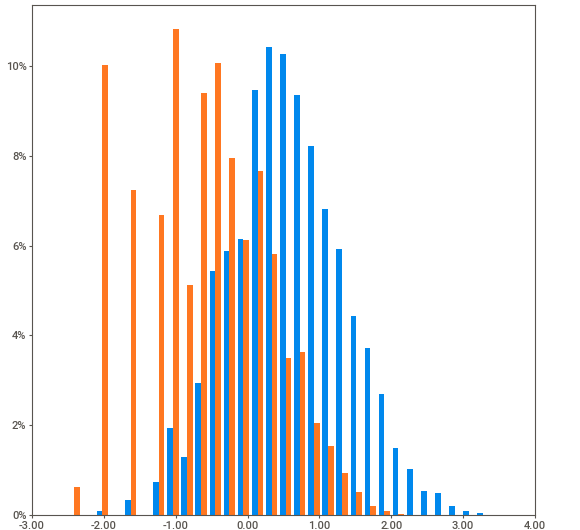
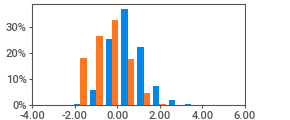
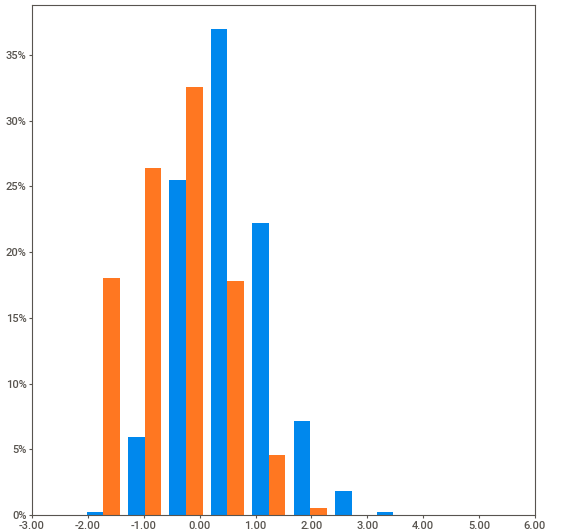
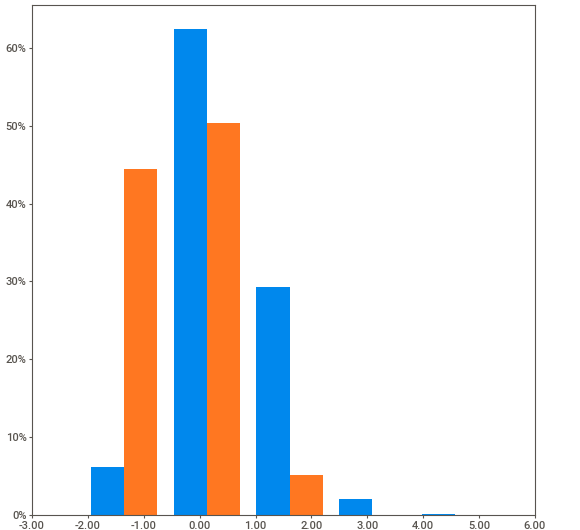
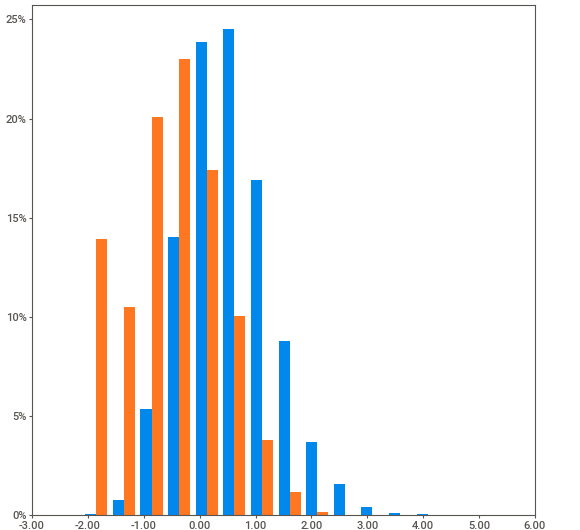
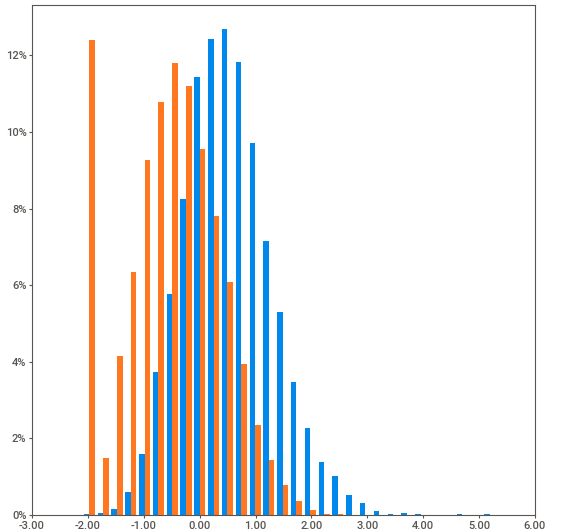
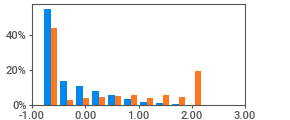
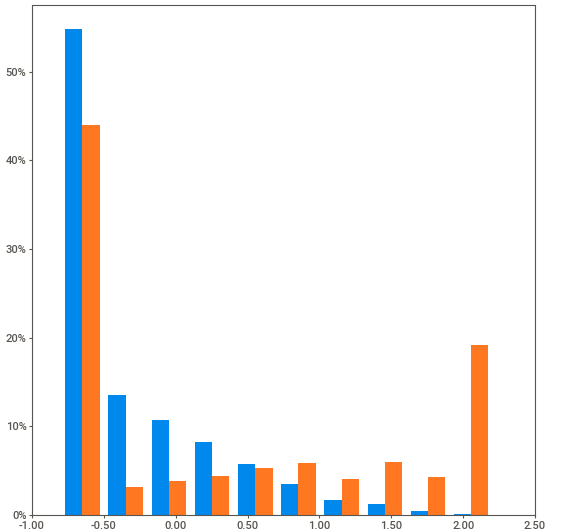
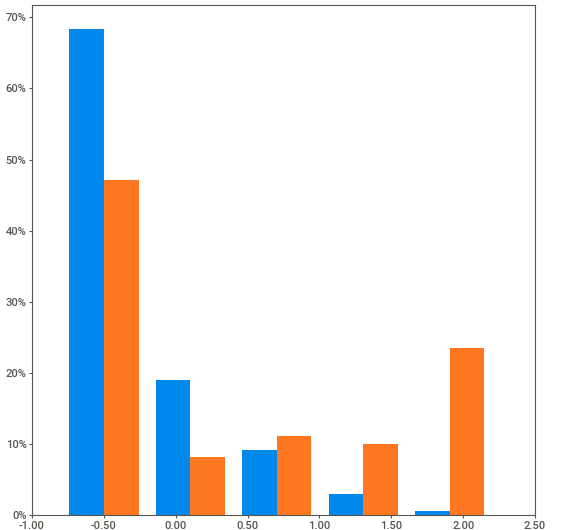
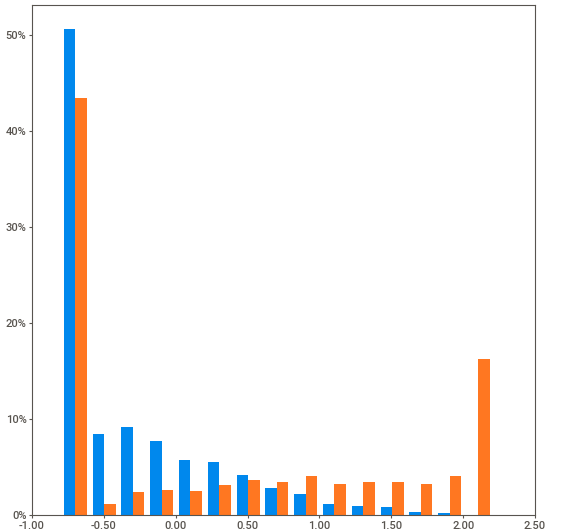
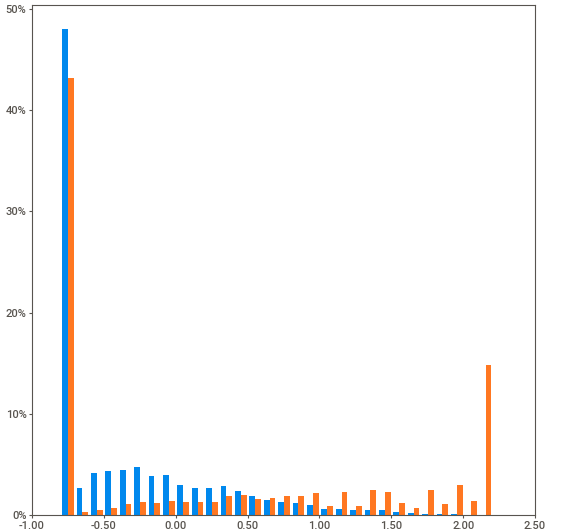
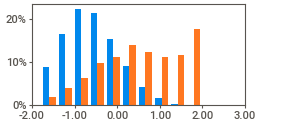
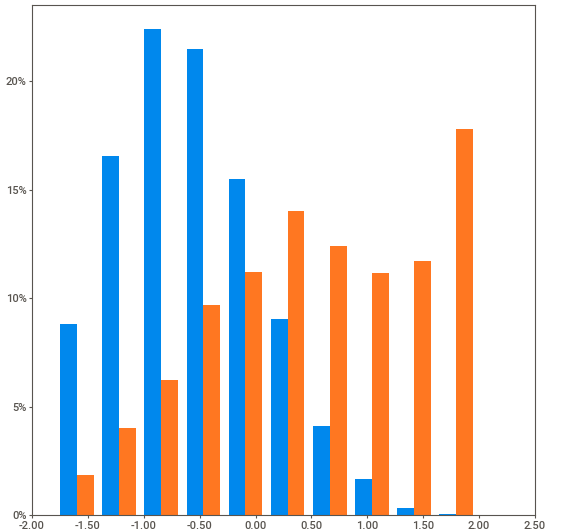
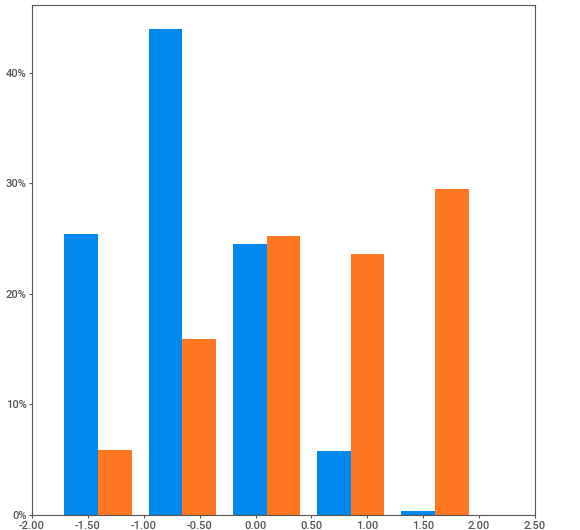
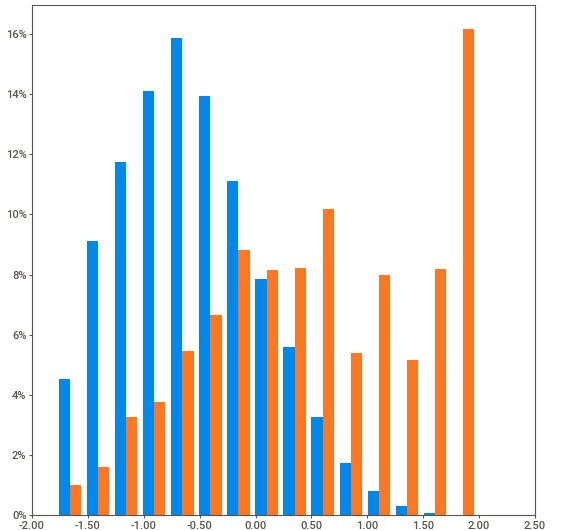
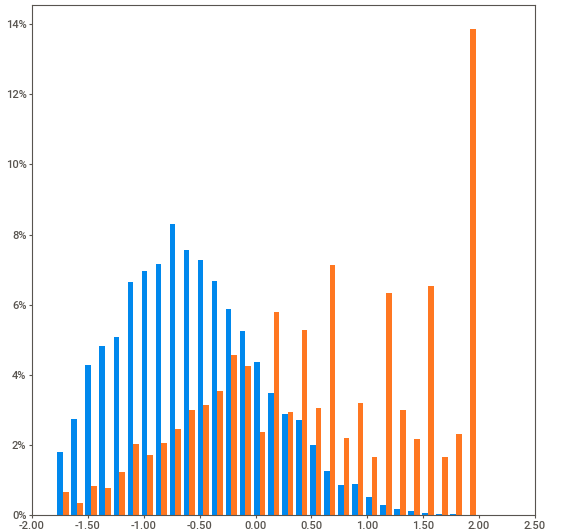
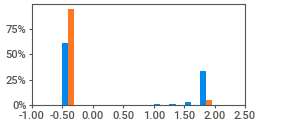
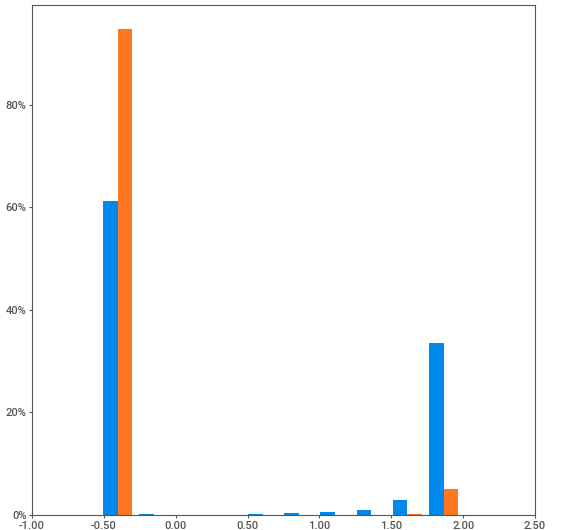
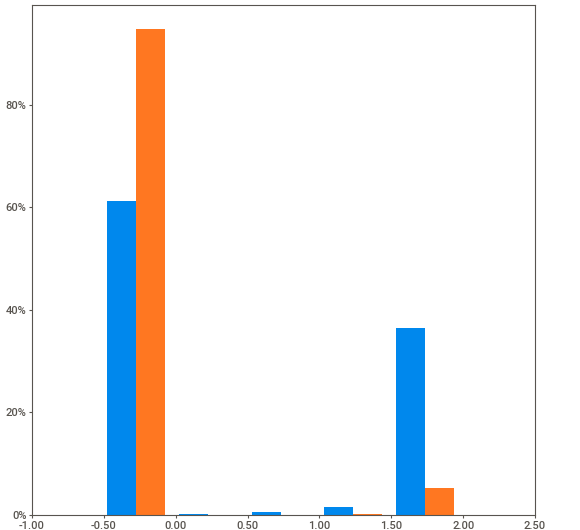
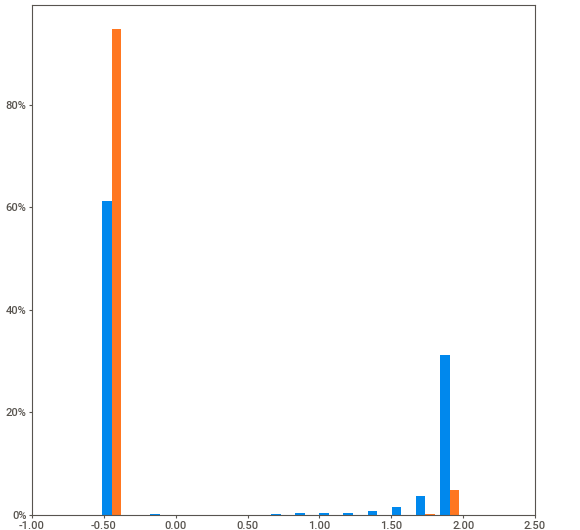
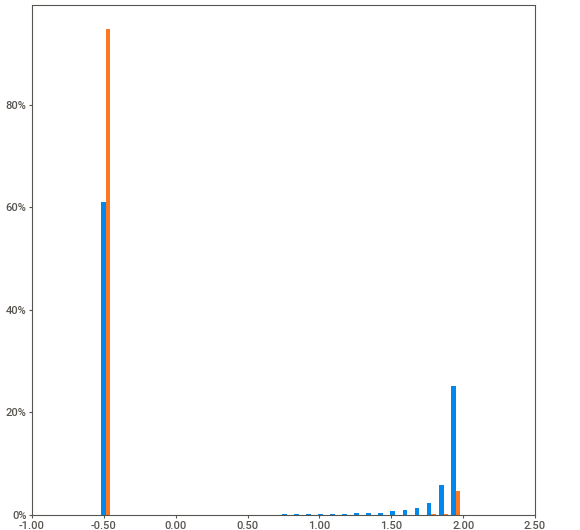
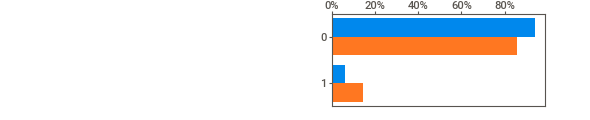
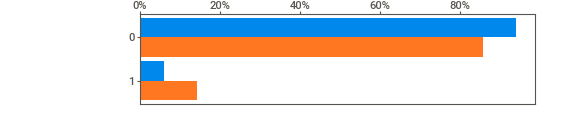
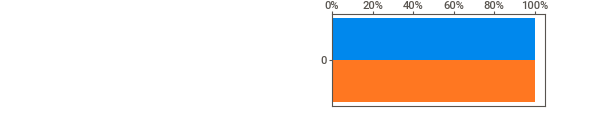
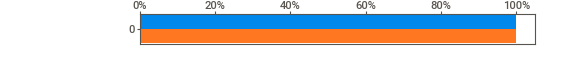
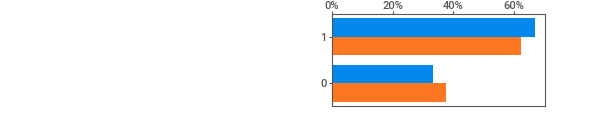
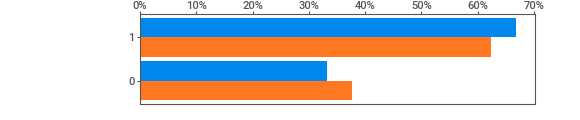
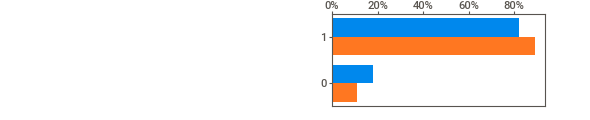
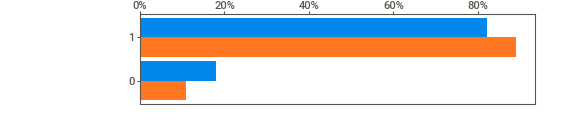
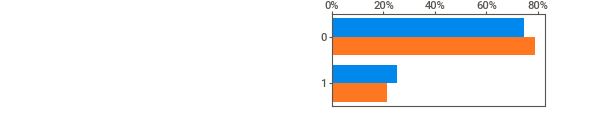
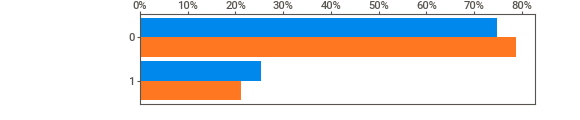
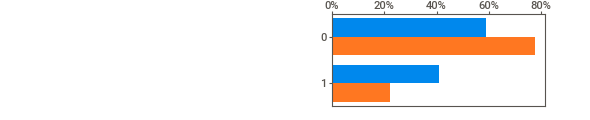
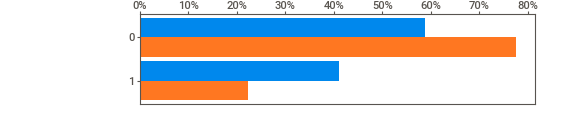
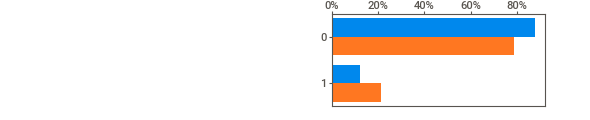
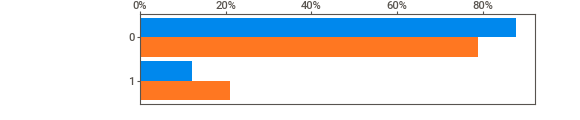
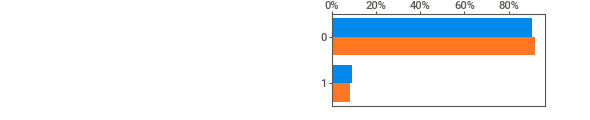
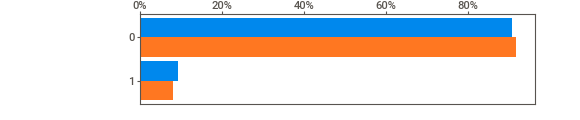
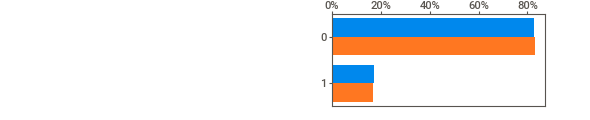
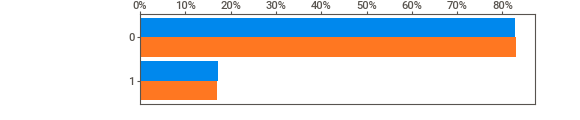
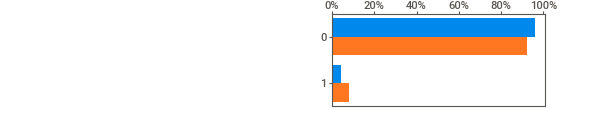
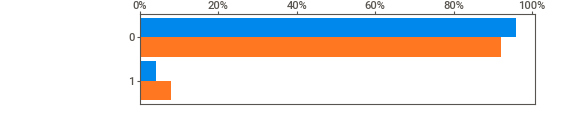
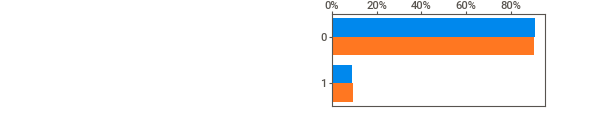
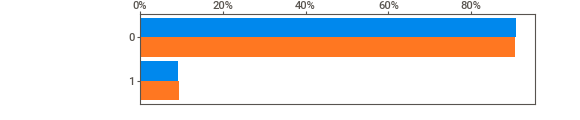
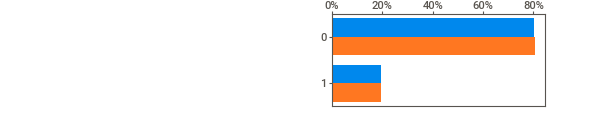
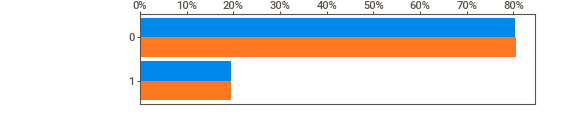
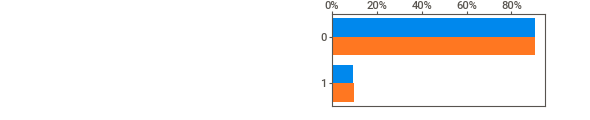
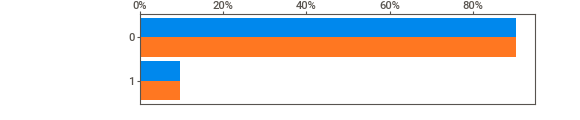
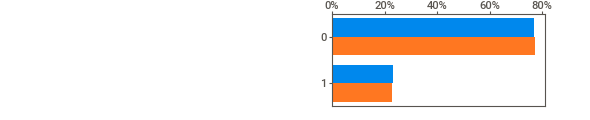
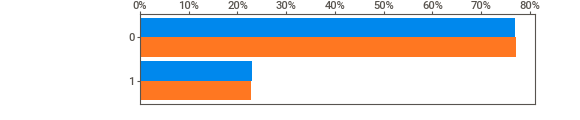
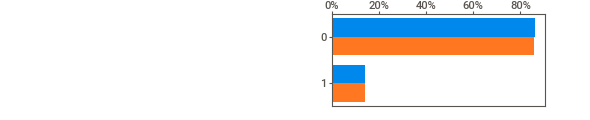
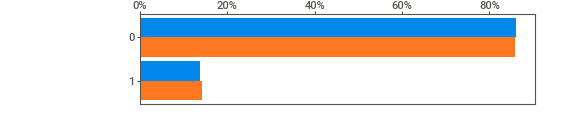
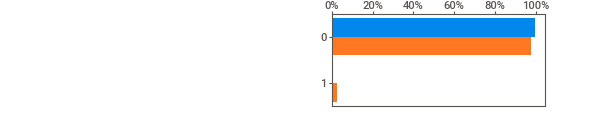
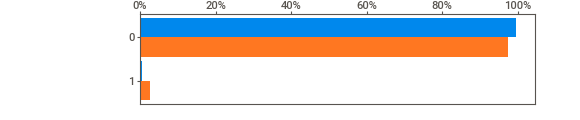
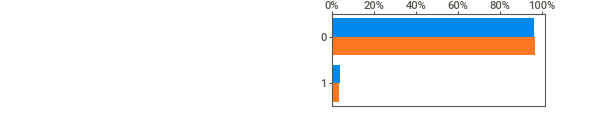
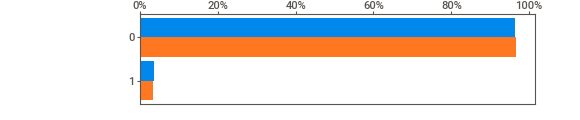
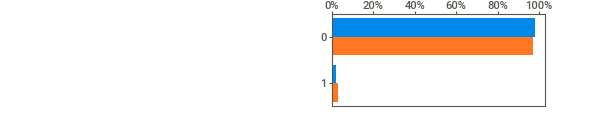
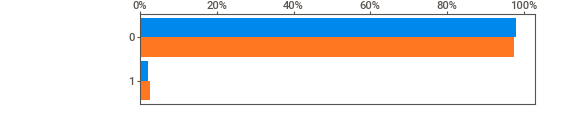
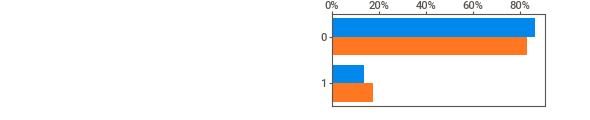
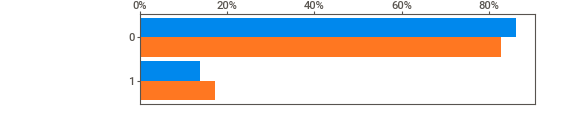
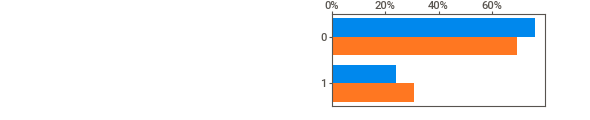
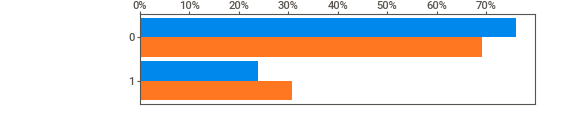
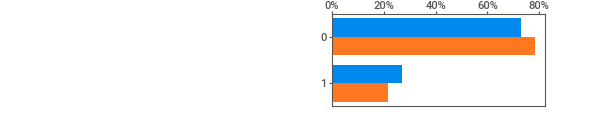
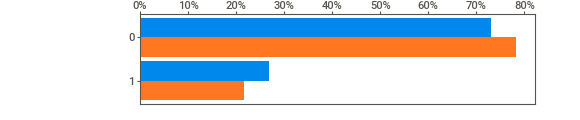
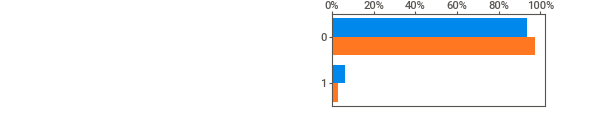
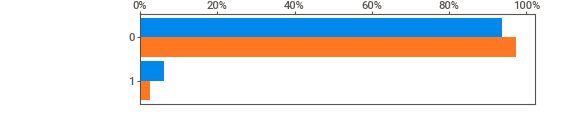
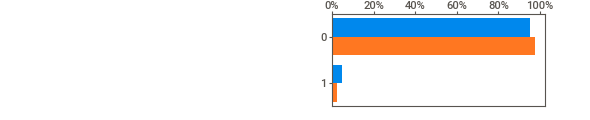
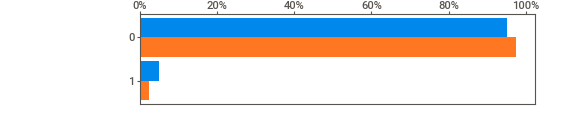
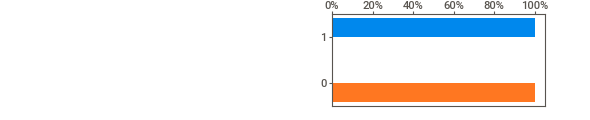
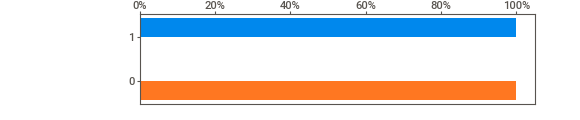
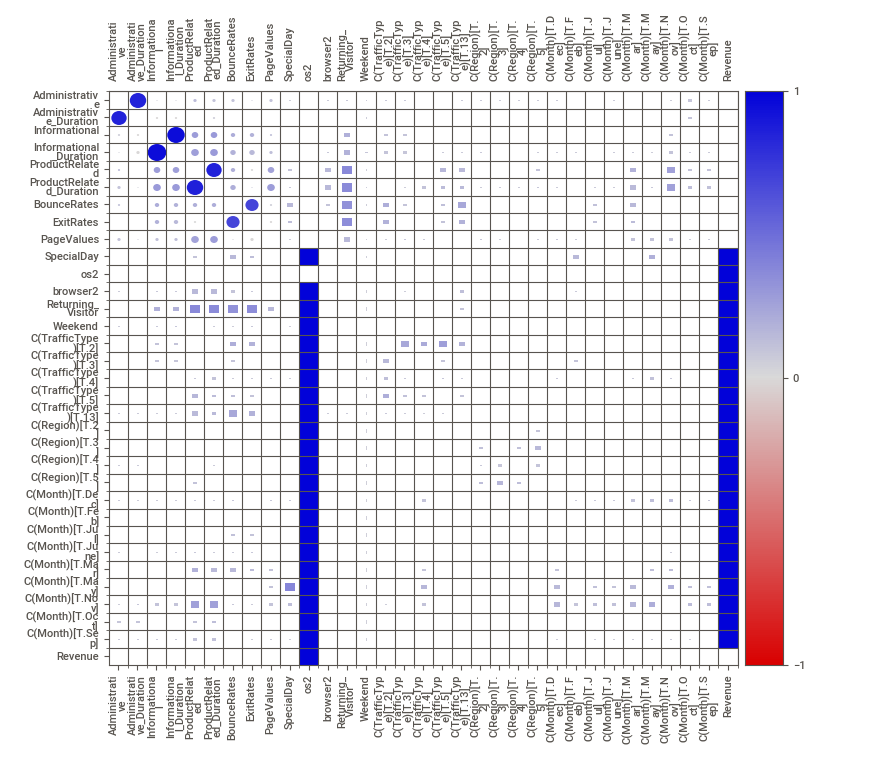
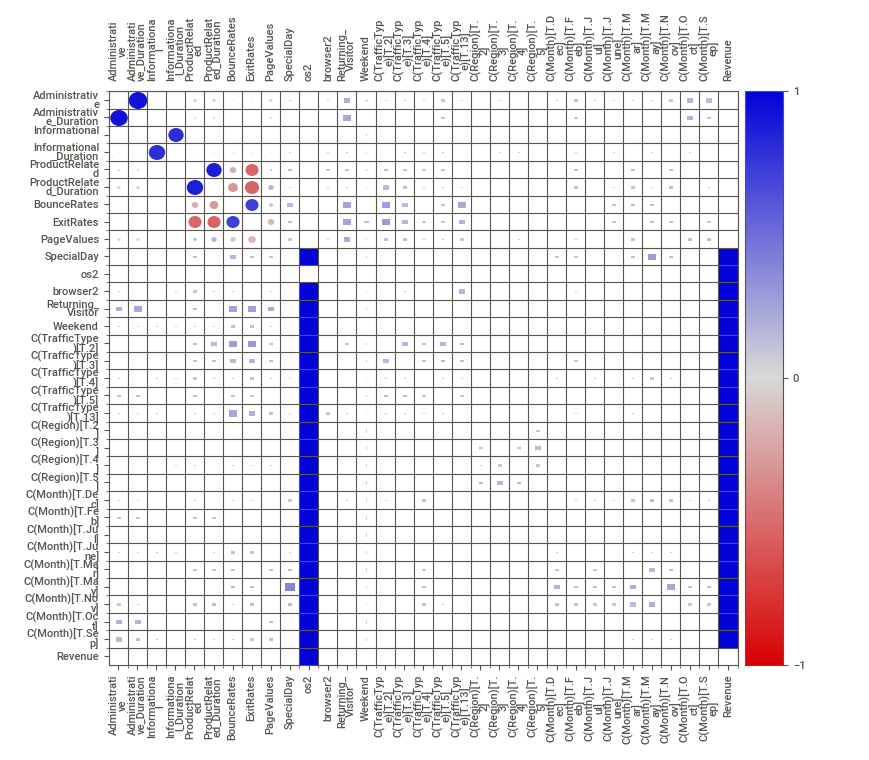

In [56]:
my_report.show_notebook(  w=None, 
                h=900, 
                scale=None,
                layout='widescreen',
                filepath=None)

**conclusions**  
From the report, we see several distinctions between our classes' specifically in the following variables.
* Administrative
* Administrative_Duration
* informational
* informational_duration
* ExitRates
* and page values

We see clear distinctions between our purchased and not purchased groups and the distribution of data.


# Clustering Output vs. Actual Labels 
We will compare the content of Revenue to the content of 
the Revenue column generated by our clustering algorithm.

We will start by comparing the count of predicted vs the actual predicted.

In [57]:
print("Actual Purchased: %f" %df_r.values.sum())
print("Predicted Purchased: %f" %df_prep.Revenue.sum())

Actual Purchased: 1908.000000
Predicted Purchased: 6174.000000


Our K-means cluster clearly over-predicted the positive cases.

In [58]:
# join the to columns to be compared together
class_compare = df_r
class_compare['V_revenue'] = df_prep.Revenue

# create a confusion matrix
pd.crosstab(class_compare.Revenue, class_compare.V_revenue)

V_revenue,0,1
Revenue,,
False,5742,4680
True,414,1494


In [59]:
print(classification_report(df_r.Revenue.astype('int'),df_prep.Revenue) )

              precision    recall  f1-score   support

           0       0.93      0.55      0.69     10422
           1       0.24      0.78      0.37      1908

    accuracy                           0.59     12330
   macro avg       0.59      0.67      0.53     12330
weighted avg       0.83      0.59      0.64     12330



https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

**conclusion** K-Means has not done a good job of classifying our data based on whether they have purchased or not. 


## Agglomerative Clustering Sanity Check

We will test to see if agglomerative clustering can do a better job  with the imbalanced class.

0    0.593836
1    0.406164
Name: Rev, dtype: float64
Nullcount: 0.000000


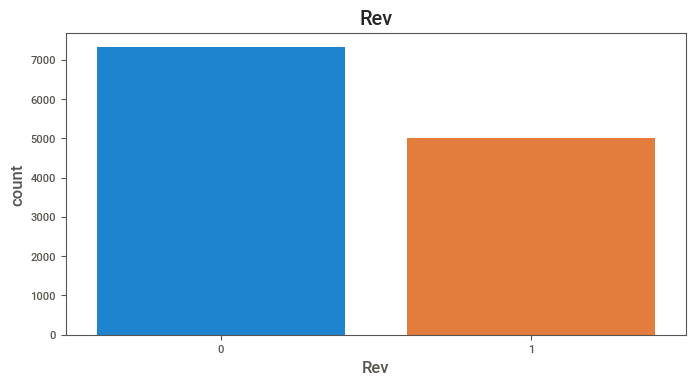

In [60]:
#agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
# set to complete linkage for 
hclust = AgglomerativeClustering(linkage='ward', n_clusters=2)
hc = hclust.fit_predict(df_prep)
df_hc = pd.DataFrame(hc, columns = ['Rev'])
#data.groupby(['target', 'h-cluster'])['target'].count()
distbox(0,df_hc,type='categorical')

It looks like using this method of clustering does a better job of identifying the proportion of users who purchased something after visiting the website. Let's examine the confusion matrix;

In [61]:
# join the to columns to be compared together
class_compare2 = df_r
class_compare2['V_revenue'] = df_hc.Rev

# create a confusion matrix
pd.crosstab(class_compare2.Revenue, class_compare2.V_revenue)

V_revenue,0,1
Revenue,,
False,5518,4904
True,1804,104


The agglomerative clustering method does a much worse job of identifying true positive cases than K-means clustering. We will use K means clustering going forward.

# SVM Modeling

We will take the following steps to implement our SVM model 
1. Feature creation
  1. We will rerun prep work on a new data_prep data frame 
  2. We will utilize patsy to create a new feature set 
    3. We will standardize and normalize variables
    4. We will dummy 
    5. We will  create interaction effect for our {page_type}:{duration} columns
  3. Create test train and validation sets
  3. We will select features recursively 
  4. We will apply features to SVM models and tune the hyperparameters 

### Data Prepparation for SVM

In [62]:
df_prep2 = df.copy()
#special day
df_prep2['SpecialDay'] = (df_prep2['SpecialDay'] != 0).astype(int)
#operatingsytems
df_prep2.insert(11, 'os2', (df_prep2['OperatingSystems'] == "2").astype(int))
df_prep2.drop(columns=['OperatingSystems'], inplace=True)
#browser
df_prep2.insert(12, 'browser2', (df_prep2['Browser'] == 2).astype(int))
df_prep2.drop(columns=['Browser'], inplace=True)
#Region
df_prep2['Region'].replace(6,5,inplace=True)
df_prep2['Region'].replace(7,5,inplace=True)
df_prep2['Region'].replace(8,5,inplace=True)
df_prep2['Region'].replace(9,5,inplace=True)
# TrafficType
df_prep2['TrafficType'].replace(6,5,inplace=True)
df_prep2['TrafficType'].replace(10,5,inplace=True)
df_prep2['TrafficType'].replace(11,5,inplace=True)
df_prep2['TrafficType'].replace(20,5,inplace=True)
df_prep2['TrafficType'].replace(8,5,inplace=True)
df_prep2['TrafficType'].replace(9,5,inplace=True)
df_prep2['TrafficType'].replace(7,5,inplace=True)
df_prep2['TrafficType'].replace(15,5,inplace=True)
df_prep2['TrafficType'].replace(19,5,inplace=True)
df_prep2['TrafficType'].replace(14,5,inplace=True)
df_prep2['TrafficType'].replace(18,5,inplace=True)
df_prep2['TrafficType'].replace(16,5,inplace=True)
df_prep2['TrafficType'].replace(12,5,inplace=True)
df_prep2['TrafficType'].replace(17,5,inplace=True)
#visitory type
df_prep2.insert(15, 'Returning_Visitor', (df_prep2['VisitorType'] == "Returning_Visitor").astype(int))
df_prep2.drop(columns=['VisitorType'], inplace=True)



### Patsy Matrix Creation

In [63]:
formula =  """standardize(Administrative) * standardize(Administrative_Duration) + standardize(Informational) * standardize(Informational_Duration) + standardize(ProductRelated) * standardize(ProductRelated_Duration) 
              + standardize(BounceRates) + standardize(ExitRates) + standardize(PageValues)+ C(TrafficType) + C(Region) + C(Month)+ Returning_Visitor + os2+ SpecialDay+ browser2"""

X = dmatrix(formula,df_prep2,return_type='dataframe')
Y = df_prep.Revenue
#sanity check
X.head()

,Intercept,C(TrafficType)[T.2],C(TrafficType)[T.3],C(TrafficType)[T.4],C(TrafficType)[T.5],C(TrafficType)[T.13],C(Region)[T.2],C(Region)[T.3],C(Region)[T.4],C(Region)[T.5],C(Month)[T.Dec],C(Month)[T.Feb],C(Month)[T.Jul],C(Month)[T.June],C(Month)[T.Mar],C(Month)[T.May],C(Month)[T.Nov],C(Month)[T.Oct],C(Month)[T.Sep],standardize(Administrative),standardize(Administrative_Duration),standardize(Administrative):standardize(Administrative_Duration),standardize(Informational),standardize(Informational_Duration),standardize(Informational):standardize(Informational_Duration),standardize(ProductRelated),standardize(ProductRelated_Duration),standardize(ProductRelated):standardize(ProductRelated_Duration),standardize(BounceRates),standardize(ExitRates),standardize(PageValues),Returning_Visitor,os2,SpecialDay,browser2
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.696993,-0.457191,0.318659,-0.396478,-0.244931,0.097110,-0.533607,-0.508335,0.271251,-0.457683,-0.298415,2.562803,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.696993,-0.457191,0.318659,-0.396478,-0.244931,0.097110,-0.398696,-0.082173,0.032762,-0.163049,0.093555,-0.317178,1.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.507228,-0.245054,-0.124298,1.178195,0.337689,0.397864,-0.623548,-0.573853,0.357825,-0.457683,-0.526248,-0.317178,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.507228,0.197324,0.100088,-0.396478,-0.244931,0.097110,-0.353725,-0.281859,0.099701,-0.457683,-0.638667,-0.317178,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.395938,-0.117771,0.046630,0.390859,-0.138354,-0.054077,-0.128873,-0.274133,0.035328,-0.457683,-0.807223,-0.317178,1.0,0.0,0.0,1.0


### SVM 1

#### Test Train Split 

In [64]:
#split training, testing, validating subsets based on code found here: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
#defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

#produces test split.
X1_remaining, X1_test, y1_remaining, y1_test = train_test_split(
    X, Y, 
    test_size=ratio_test, 
    random_state=42
    )

#adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

#produces train and val splits.
X1_train, X1_val, y1_train, y1_val = train_test_split(
    X1_remaining, y1_remaining, 
    test_size=ratio_val_adjusted,
    random_state=42
   )

#### Null Error Rate
We will calculate the null rate now to have something to compare our model performance to.

In [65]:
(len(X1_train)-y1_train.sum())/len(X1_train)#total count minus positive count divided by total count

0.49706001622060014

This error rate makes sense because we have two evenly distributed classes in our clusters.

#### Feature Selection
We will utilize MLextends sequential feature selection function and a decision tree to find the best set of features for our model 

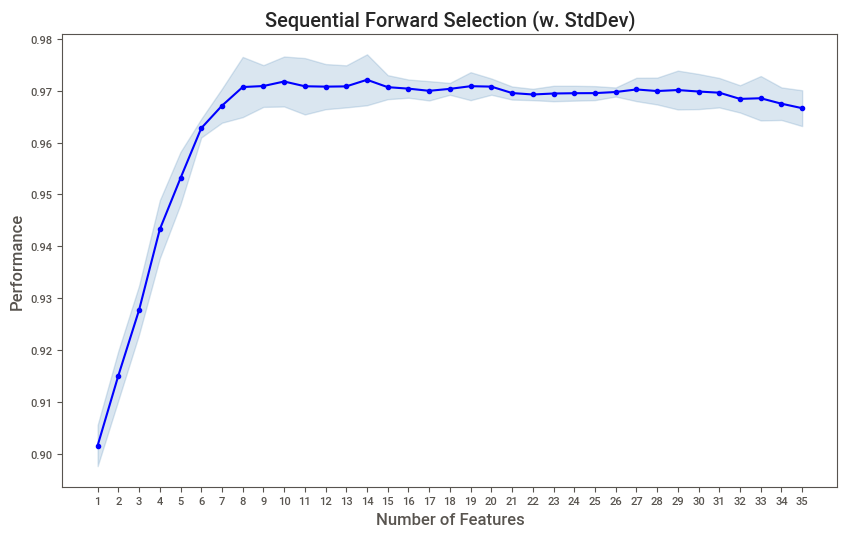

In [66]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
sfs = SFS(model, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='f1',
          verbose=0,
          n_jobs=-1,
          cv=5)
sfs = sfs.fit(X1_train, y1_train)

plot = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.show()

In [67]:
# identifying the selected features
features = sfs.k_feature_names_
features

('Intercept',
 'C(TrafficType)[T.3]',
 'C(Region)[T.2]',
 'C(Month)[T.Mar]',
 'standardize(Administrative)',
 'standardize(Administrative):standardize(Administrative_Duration)',
 'standardize(Informational)',
 'standardize(Informational_Duration)',
 'standardize(ProductRelated)',
 'standardize(ProductRelated_Duration)',
 'standardize(BounceRates)',
 'standardize(ExitRates)',
 'standardize(PageValues)',
 'os2')

#### Model

In [68]:
from sklearn.svm import SVC

X1_train_sub = X1_train.loc[:,features]
X1_test_sub =  X1_test.loc[:,features]
svc = SVC(random_state=42, 
           probability=True,
           C=1,
           kernel= 'sigmoid' #sigmoid kernal trick is only one that is able to prperly classify data
           )
svc.fit(X1_train_sub, y1_train)

SVC(C=1, kernel='sigmoid', probability=True, random_state=42)

#### Evaluation metrics

In [69]:
#accuracy
svc.score(X1_test_sub, y1_test)

0.829683698296837

In [70]:
y1_pred = svc.predict(X1_test_sub)
print(confusion_matrix(y1_test, y1_pred))
print(classification_report(y1_test, y1_pred))

[[534 110]
 [100 489]]
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       644
           1       0.82      0.83      0.82       589

    accuracy                           0.83      1233
   macro avg       0.83      0.83      0.83      1233
weighted avg       0.83      0.83      0.83      1233



This approach has a much higher accuracy rate than the null error rate. We have increased our accuracy by 30% against our clustered labels.

### SVM 2

We will use a recursive feature elimination model along with the logistic regression for our second SVM model.

#### Test Train Split

In [71]:
#split training, testing, validating subsets based on code found here: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
X2_remaining, X2_test, y2_remaining, y2_test = train_test_split(
    X, Y, 
    test_size=ratio_test, 
    random_state=42
    )


# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X2_train, X2_val, y2_train, y2_val = train_test_split(
    X2_remaining, y2_remaining, 
    test_size=ratio_val_adjusted,
    random_state=42
   )

#### Feature Selection

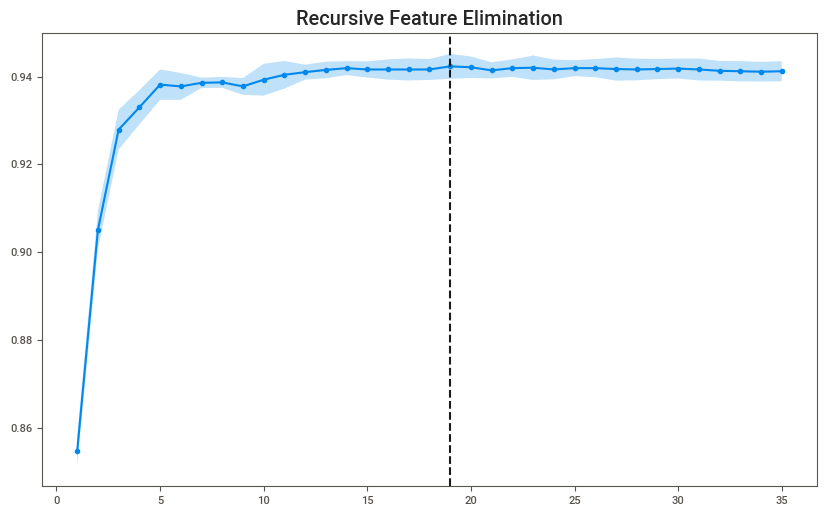

In [72]:
model = LogisticRegression(max_iter=1000)
visualizer = RFECV(model,
                   scoring='f1_weighted', 
                   cv=5,
                   )
plt.title('Recursive Feature Elimination')
visualizer.fit(X2_train,np.ravel(y2_train));

In [73]:
# what columns were dropped by RFE
X.columns[~visualizer.support_]

Index(['Intercept', 'C(TrafficType)[T.3]', 'C(TrafficType)[T.4]',
       'C(TrafficType)[T.5]', 'C(TrafficType)[T.13]', 'C(Region)[T.3]',
       'C(Region)[T.5]', 'C(Month)[T.Jul]', 'C(Month)[T.Mar]',
       'C(Month)[T.May]', 'C(Month)[T.Oct]', 'C(Month)[T.Sep]',
       'standardize(ProductRelated):standardize(ProductRelated_Duration)',
       'os2', 'SpecialDay', 'browser2'],
      dtype='object')

#### Model

In [74]:
X2_train_sub = X2_train.loc[:,visualizer.support_]
X2_test_sub =  X2_test.loc[:,visualizer.support_]
svc2 = SVC(random_state=42, 
           probability=True,
           C=1,
           kernel= 'sigmoid' #sigmoid kernal trick is only one that is able to prperly classify data
           )
svc2.fit(X2_train_sub, y2_train)

SVC(C=1, kernel='sigmoid', probability=True, random_state=42)

#### Evaluation Metrics

In [75]:
y2_pred = svc2.predict(X2_test_sub)

print(f'Model accuracy = {svc2.score(X2_test_sub, y2_test)}\n')
print(confusion_matrix(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

Model accuracy = 0.870235198702352

[[552  92]
 [ 68 521]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       644
           1       0.85      0.88      0.87       589

    accuracy                           0.87      1233
   macro avg       0.87      0.87      0.87      1233
weighted avg       0.87      0.87      0.87      1233



This feature selection improves upon our first model. We will compare and select our preferred model below.

# Select Models

## Model Summary

| Model  | Precision | Recall | F1  | Accuracy |
|:-:|     :-:|:-:|:-:  |:--:|
| Model 1 | .82 | .83 | .83  | .833 |   
| Model 2 | .85 | .88 | .87  | .870|  



## Model Validation

In [76]:
#accuracy score of validation set.
visualizer.score(X2_val, y2_val)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RFE was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.9513381995133819

In [77]:
X2_val_sub = X2_val.loc[:,visualizer.support_]

y2_pred = svc2.predict(X2_val_sub)

print(f'Model accuracy = {svc2.score(X2_val_sub, y2_val)}\n')
print(confusion_matrix(y2_pred, y2_val))
print(classification_report(y2_pred, y2_val))

Model accuracy = 0.8872668288726683

[[539  69]
 [ 70 555]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       608
           1       0.89      0.89      0.89       625

    accuracy                           0.89      1233
   macro avg       0.89      0.89      0.89      1233
weighted avg       0.89      0.89      0.89      1233



**conclusions:**   
All of our metrics have improved on the hold out set. Our model appears to generalize very well. we will next see how it does at predicting actual revenue.

# Clustering + SVM Output vs. Actual Labels

In [78]:
pred_labels = svc2.predict(X.loc[:,visualizer.support_])
df_final = pd.DataFrame(pred_labels, columns = ['predicted'])
df_final['actual'] = df_r['Revenue']
df_final.head()

,predicted,actual
0,0,True
1,0,False
2,1,False
3,1,False
4,1,False


In [79]:
pd.crosstab(df_final.actual, df_final.predicted)

predicted,0,1
actual,,
False,5640,4782
True,471,1437


**conclusions** we see a high number of false positives in our confusion matrix.

In [80]:
print(classification_report(df_final.actual.astype('int'),df_final.predicted) )

              precision    recall  f1-score   support

           0       0.92      0.54      0.68     10422
           1       0.23      0.75      0.35      1908

    accuracy                           0.57     12330
   macro avg       0.58      0.65      0.52     12330
weighted avg       0.82      0.57      0.63     12330



**Conclusions** our SVM model does not score well at trying to predict purchase but it was not trained to do so so this is not an unexpected result.

# Final Conclusion

Our SVM model does a good job of predicting our k-means clusters, but this does not translate to a successful pedication of purchase model; whether or not people browsing the website will make a purchase. Our K-means model found clusters with proportional labels, which did not match the real-world data we were comparing against. 

Further lines of research include:
* Can we create a good predictive model utilizing our labeled data?
* Can we understand in greater detail what was driving the K-means clusters and whether this has any business value.
